In [1]:
import os
import string
import torch
from torch import nn
from torch.nn import functional as F
if not "CHDIR_FLAG" in dir():
    os.chdir("../")
    CHDIR_FLAG = True
    
import numpy as np
import pandas as pd
from safetensors import safe_open
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

from src.tools.transformers import greedy_decode
from src.tools.plot import plot_tensor_mean_and_variance, plot_tensor_histogram, plot_tensor_heatmap
from src.tools.torch import register_forward_hook_decorator, register_backward_hook_decorator

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
torch.__version__

'2.6.0+cpu'

# Preliminary

1. Âú®‰πãÂâçÁöÑÁ†îÁ©∂‰∏≠ÔºåÊàë‰ª¨ÂèëÁé∞Èù†ÂêéÁöÑÂ±ÇÂÖ∑ÊúâÊõ¥ÈáçË¶ÅÁöÑ‰ΩúÁî®ÔºüÊòØÂê¶ÊúâÂèØËÉΩ‰∏¢ÂºÉ‰∏Ä‰∫õ‰∏çÈáçË¶ÅÁöÑÂ±ÇÔºü
  - ÂÆûÈ™åÈ™åËØÅÂèëÁé∞ÔºåÂç≥‰æøË∑≥Ëøá‰∏Ä‰∫õÈöêÂ±ÇÔºåÂπ∂‰∏çÂΩ±ÂìçËæìÂá∫ÁöÑÂèØË°åÊÄßÔºå
  
2. ÂêåÁêÜÂú®‰πãÂâçÈíàÂØπLoRAÂùóÁöÑÂ•áÂºÇÂÄºÂàÜÊûê‰∏≠ÂèëÁé∞ÔºåÊüê‰∫õÊÉÖÂÜµ‰∏ãÔºåv_proj ÁöÑÁ°ÆÊòØ‰ΩéÁß©ÁöÑÔºåËøúËøú‰∏çÂ¶Ç q_proj Âíå k_projÔºåÁåúÊÉ≥‰∏∫ v_proj ÂèØËÉΩ‰∏çÂÄºÂæóË∞É‰ºò
  
  
ÂºïÂá∫ÂèØËÉΩÁöÑÁ†îÁ©∂ÊÄùË∑ØÔºö

1. ÊòØÂê¶Âú®PEFT‰∏≠ÂèØ‰ª•Âè™ÂØπÂåÖÂê´‰ø°ÊÅØÈáèÂ§öÁöÑÂ±ÇÁöÑQKVËøõË°åÂæÆË∞É

  - ÊâÄË∞ìÂåÖÂê´‰ø°ÊÅØÂ§öÁöÑÂ±ÇÔºåÊåáÁöÑÊòØÂ±ÇÁöÑËæìÂÖ•ÂíåËæìÂá∫Â∑ÆÂºÇËæÉÂ§ß
  - **‰ΩÜÊòØËøô‰ª∂‰∫ãÊÉÖÂèçËøáÊù•ËØ¥‰πüÊòØ‰∏ÄÊ†∑ÁöÑÔºå‰πüËÆ∏ÂÖ∂‰ªñÂ±ÇËæìÂÖ•ËæìÂá∫Â∑ÆÂºÇÂ∞èÔºåÂõ†Ê≠§ÂåÖÂê´ÁöÑ‰ø°ÊÅØÂ∞ëÔºåÂèØËÉΩÂ∞±ÊòØÊ®°ÂûãÁïôÂá∫ÁöÑ‚ÄúÂÆπÈáè‚ÄùÊù•Â≠¶‰π†ÂÖ∂‰ªñÁü•ËØÜÔºåÂõ†Ê≠§Êõ¥ÈúÄË¶ÅÂéªÂæÆË∞É**
2. Ëøô‰ª∂‰∫ãÊú¨Ë∫´‰πüÂèØ‰ª•ÂíåQKV LoRAÂùóÁöÑ‰ø°ÊÅØÈáèËøõË°å‰∫§ÂèâÈ™åËØÅ
3. Layer-SkipÁöÑÂèØË°åÊÄßÔºüËã•ÂèØË°åÔºåÂàôÊé¢ËÆ®SkipÁöÑÁªÑÂêàÊñπÊ≥ïÔºü

In [2]:
model_home = r"D:\resource\model\huggingface"
model_names = [
    r"Qwen\Qwen2.5-0.5B-Instruct",
    r"deepseek-ai\DeepSeek-R1-Distill-Qwen-1.5B",
]
hook_data_paths = [
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-0.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-1.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-2.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-3.pt",
]
hook_data_paths = [
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-0.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-1.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-2.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-3.pt",
]

# -*- coding: utf8 -*-
# @author: caoyang
# @email: caoyang@stu.sufe.edu.cn

import logging
from copy import deepcopy
from functools import wraps
from src.tools.hook import register_forward_hook_decorator, register_backward_hook_decorator

def get_generation_eos_token_ids(model):
    eos_token_id = model.generation_config.eos_token_id
    if isinstance(eos_token_id, int):
        eos_token_ids = [eos_token_id]
    elif isinstance(eos_token_id, list):
        eos_token_ids = eos_token_id[:]
    else:
        logging.warning(f"Unknown type of EOS: {eos_token_id}")
        eos_token_ids = [151643, 151645]	# Default EOS token for Qwen model
    return eos_token_ids

def get_generation_bos_token_ids(model):
    bos_token_id = model.generation_config.bos_token_id
    if isinstance(bos_token_id, int):
        bos_token_ids = [bos_token_id]
    elif isinstance(bos_token_id, list):
        bos_token_ids = bos_token_id[:]
    else:
        logging.warning(f"Unknown type of BOS: {bos_token_id}")
        bos_token_ids = [151646]	# Default EOS token for Qwen model
    return bos_token_ids	

# Standard greedy decode supporting hook registration
# @param model: Huggingface model object
# @param tokenizer: Huggingface tokenizer Object
# @param prompt: [Str]
# @param max_length: [Int]the number of tokens to be generated (exclude `prompt`)
# @param device: [Str] e.g. "cuda" or "cpu"
# @param use_kv_cache: [Boolean] whether to use KV-cache to accelerate, if True then large memory will be consumed
# @param forward_hook_module_names: [List[Str]] Default None, otherwise register forward hook for `forward_hook_module_names`, e.g. ["model.layers[0].self_attn.q_proj", "model.layers[0].self_attn.k_proj"]
# @param backward_hook_module_names: [List[Str]] Default None, otherwise register backward hook for `backward_hook_module_names`, e.g. ["model.layers[0].self_attn.q_proj", "model.layers[0].self_attn.k_proj"]
# @return returned_dict: [Dict]
# - "text": [Str]
# - "token_probs": List[Tuple(Int, Str, Float)], `len(generated_id_prob)` is `max_length`, indicating the generated probability of each token
# - "logits": Tuple[FloatTensor(1, n_vocab)], `len(generated_logits)` is `max_length`, indicating the logits when each token is generated
# - "forward_hook_data": List of hook data (length is `max_length`) in format of [Dict[<module_name>: Dict]], Read `hook_data` in `src.tools.hook.register_forward_hook_decorator` for details
# - "backward_hook_data": List of hook data (length is `max_length`) in format of [Dict[<module_name>: Dict]], Read `hook_data` in `src.tools.hook.register_backward_hook_decorator` for details
def greedy_decode(model,
                  tokenizer,
                  prompt, 
                  max_length,
                  device = "cuda",
                  use_kv_cache = True,
                  forward_hook_module_names = None,
                  backward_hook_module_names = None,
                  skip_layer_idx = list(),
                  layer_order = None,
                  ):
    if forward_hook_module_names is None and backward_hook_module_names is None:
        hook_flag = 0
        def easy_forward(inputs, *, model, **kwargs):
            return model(inputs, **kwargs)
    elif not (forward_hook_module_names is None or backward_hook_module_names is None):
        hook_flag = -1
        raise NotImplementedError("Simultaneous use of forward and backward hook!")
    else:
        if forward_hook_module_names is not None:
            hook_flag = 1
            @register_forward_hook_decorator(module_names = forward_hook_module_names)
            def easy_forward(inputs, *, model, **kwargs):
                return model(inputs, **kwargs)
        else:
            hook_flag = 2
            @register_backward_hook_decorator(module_names = forward_hook_module_names)
            def easy_forward(inputs, *, model, **kwargs):
                return model(inputs, **kwargs)

    eos_token_ids = get_generation_eos_token_ids(model)
    logging.info(f"EOS token: {eos_token_ids}")
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)	# Str => Long(1, n_tokens)
    past_key_values = None
    generated_token_probs = list()
    generated_logits = list()
    forward_hook_data = None
    backward_hook_data = None
    if hook_flag == 1:
        forward_hook_data = list()
    if hook_flag == 2:
        backward_hook_data = list()	
    for i in range(max_length):
        # logging.info(f"Round {i}: {past_key_values.key_cache[0].size() if past_key_values is not None else None}")
        with torch.no_grad():
            if use_kv_cache:
                if past_key_values is None:
                    outputs = easy_forward(inputs, model=model, past_key_values=None, skip_layer_idx=skip_layer_idx, layer_order=layer_order)
                else:
                    outputs = easy_forward(inputs[:, -1].unsqueeze(0), model=model, past_key_values=past_key_values, use_cache=True, skip_layer_idx=skip_layer_idx, layer_order=layer_order)
                past_key_values = outputs.past_key_values	# Dictlike[key_cache: Float(1, 2, X, hidden_size), value_cache: Float(1, 2, X, hidden_size)], where X = (i + 1) * (n_tokens + i / 2)
            else:
                outputs = easy_forward(inputs, model=model, past_key_values=None, use_cache=False, skip_layer_idx=skip_layer_idx, layer_order=layer_order)
            logits = outputs.logits	# Float(1, n_tokens + i + 1, n_vocab), where `n_vocab` is 151936 in Qwen-series
            next_token_probs = F.softmax(logits[:, -1, :], dim=-1)	# Float(1, n_tokens + i + 1, n_vocab) => Float(1, n_vocab)
            next_token_id = torch.argmax(next_token_probs, dim=-1)	# Float(1, n_vocab) => Long(1, )
            next_token_prob = next_token_probs[0, next_token_id].item()	# Float(1, n_vocab) => Float()
            next_token = tokenizer.decode(next_token_id[0].item(), skip_special_tokens=False)	# Long(1, ) => Str
            inputs = torch.cat([inputs, next_token_id.unsqueeze(-1)], dim=-1)	# Long(1, n_tokens + i) => Long(1, n_tokens + i + 1)
            generated_token_probs.append((next_token_id.item(), next_token, next_token_prob))	# List[] <- (Int, Str, Float)
            generated_logits.append(logits[:, -1, :])	# List[] <- Float(1, n_vocab)
            # Process hook data
            if hook_flag > 0:
                hook_data = outputs.hook_outputs
                if hook_flag == 1:
                    forward_hook_data.append(hook_data)
                else:
                    backward_hook_data.append(hook_data)
            if next_token_id in eos_token_ids:
                # Early stop at EOS
                break
    generated_text = tokenizer.decode(
        token_ids = inputs[0], 
        skip_special_tokens=True, 
        clean_up_tokenization_spaces=True,
    )	# Long(1, n_tokens + max_length) => Str
    return {
        "text": generated_text,
        "token_probs": generated_token_probs,
        "logits": tuple(generated_logits),
        "forward_hook_data": forward_hook_data,
        "backward_hook_data": backward_hook_data,
    }

# Skip-LayerÁîüÊàêÊ°à‰æãÂàÜÊûêÔºàQwen2.5B-InstructÔºâ

ÁõÆÂâçÊµãËØïÊñπÊ≥ïÊòØÁªô `Qwen2Model` Ê∫êÁ†ÅÂä†‰∫Ü‰∏Ä‰∏™ÂèÇÊï∞ `skip_layer_idx`

‰øÆÊîπÔºö`E:\Anaconda3\envs\myopenai\Lib\site-packages\transformers\models\qwen2\modeling_qwen2.py` ÁöÑ516Ë°åÂä†‰∫ÜÂèÇÊï∞ `skip_layer_idx`ÔºåÁÑ∂ÂêéÂú®570Ë°åÂ∑¶Âè≥Âä†ÂÖ• `skip_layer_idx` ÁöÑÊìç‰ΩúÔºö

```python
for i, decoder_layer in enumerate(self.layers[: self.config.num_hidden_layers]):
    if i in skip_layer_idx:
        continue
    if output_hidden_states:
        all_hidden_states += (hidden_states,)

    if self.gradient_checkpointing and self.training:
        layer_outputs = self._gradient_checkpointing_func(
            decoder_layer.__call__,
            hidden_states,
            causal_mask,
            position_ids,
            past_key_values,
            output_attentions,
            use_cache,
            cache_position,
            position_embeddings,
        )
    else:
        layer_outputs = decoder_layer(
            hidden_states,
            attention_mask=causal_mask,
            position_ids=position_ids,
            past_key_value=past_key_values,
            output_attentions=output_attentions,
            use_cache=use_cache,
            cache_position=cache_position,
            position_embeddings=position_embeddings,
            **flash_attn_kwargs,
        )
```

ÈíàÂØπ `Qwen2.5-0.5B-Instruct` Â∑≤ÁªèÊµãÂá∫ÁöÑ‰∏Ä‰∫õÁªìÊûúÔºö

1. `skip_layer_idx = [8]`Ôºå‰æùÁÑ∂ÂèØ‰ª•Ê≠£Â∏∏ËæìÂá∫

In [3]:
tokenizer = AutoTokenizer.from_pretrained(os.path.join(model_home, model_names[0]))
model = AutoModelForCausalLM.from_pretrained(os.path.join(model_home, model_names[0]))

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [4]:
prompt = "For how many positive integers n > 1 is"
max_length = 128

In [5]:
# Ê†áÂáÜÁöÑËß£Á†ÅÁîüÊàêÁªìÊûú
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
print(results["text"])

For how many positive integers n > 1 is 1^n + 2^n + 3^n + 4^n a multiple of 15?
To determine for how many positive integers \( n > 1 \) the expression \( 1^n + 2^n + 3^n + 4^n \) is a multiple of 15, we need to analyze the expression modulo 15. We will consider the possible values of \( n \mod 15 \) and determine the corresponding values of \( 1^n + 2^n + 3^n + 4^n \mod 15 \).

First, note that \( 1^n


## Case 1 Âæà‰πÖÂæà‰πÖ‰ª•ÂâçÔºå

In [5]:
prompt = "Âæà‰πÖÂæà‰πÖ‰ª•Ââç"
max_length = 128

### Ê†áÂáÜËæìÂá∫

In [6]:
# Ê†áÂáÜÁöÑËß£Á†ÅÁîüÊàêÁªìÊûú
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
print(results["text"])

Âæà‰πÖÂæà‰πÖ‰ª•ÂâçÔºåÊàëÊúâ‰∏Ä‰∏™ÊúãÂèãÔºå‰ªñÊòØ‰∏™ÈùûÂ∏∏ÊúâÊâçÂçéÁöÑ‰∫∫Ôºå‰ªñÊÄªÊòØÂñúÊ¨¢Âú®Ëá™Â∑±ÁöÑ‰ΩúÂìÅ‰∏≠Âä†ÂÖ•‰∏Ä‰∫õÁã¨ÁâπÁöÑÂÖÉÁ¥†ÔºåÊØîÂ¶ÇÁî®‰∏çÂêåÁöÑÈ¢úËâ≤„ÄÅ‰∏çÂêåÁöÑÂΩ¢Áä∂„ÄÅ‰∏çÂêåÁöÑÁ∫πÁêÜÁ≠âÔºå‰Ωø‰ΩúÂìÅÊõ¥Âä†ÁîüÂä®ÊúâË∂£„ÄÇ‰ªñÁöÑ‰ΩúÂìÅÁªèÂ∏∏Ë¢´‰∏Ä‰∫õÁü•ÂêçËâ∫ÊúØÂÆ∂ÁöÑ‰ΩúÂìÅÊâÄÂÄüÈâ¥ÂíåÊ®°‰ªøÔºåÁîöËá≥Âú®‰∏Ä‰∫õËâ∫ÊúØÂ±ïËßà‰∏äÂ±ïÂá∫„ÄÇ‰ªñÁöÑ‰ΩúÂìÅÂèóÂà∞‰∫ÜÂæàÂ§ö‰∫∫ÁöÑÂñúÁà±ÂíåËøΩÊçßÔºåÁîöËá≥Êúâ‰∫∫ËÆ§‰∏∫‰ªñÊòØÂΩì‰ª£Ëâ∫ÊúØÁöÑÂÖàÈ©±ËÄÖ„ÄÇ

ÁÑ∂ËÄåÔºåÈöèÁùÄÊó∂Èó¥ÁöÑÊé®ÁßªÔºåÊàëÂèëÁé∞‰ªñ‰ºº‰πé‰∏çÂÜçÂÉè‰ª•ÂâçÈÇ£Ê†∑ÊúâÊâçÂçé‰∫Ü„ÄÇ‰ªñÁöÑ‰ΩúÂìÅ‰∏çÂÜçÈÇ£‰πàÁã¨ÁâπÔºå‰πü‰∏çÂÜçÊúâÈÇ£‰πàÂ§öÁöÑÂàõÊñ∞ÊÄß„ÄÇ‰ªñÁöÑ‰ΩúÂìÅÂèòÂæóË∂äÊù•Ë∂äÂπ≥Â∫∏Ôºå‰∏çÂÜçÊúâÈÇ£‰πàÂ§ßÁöÑËâ∫ÊúØ


In [9]:
df = pd.DataFrame(results["token_probs"], columns=["id", "token", "prob"])
df

id  token      prob
0      3837      Ôºå  0.574743
1     35946      Êàë  0.056853
2    104133    Êúâ‰∏Ä‰∏™  0.042239
3     99614     ÊúãÂèã  0.173688
4      3837      Ôºå  0.300132
5     42411      ‰ªñ  0.269007
6    104104     ÊòØ‰∏™  0.066669
7     99491     ÈùûÂ∏∏  0.054581
8     18830      Êúâ  0.137744
9    112283     ÊâçÂçé  0.237275
10   100623     ÁöÑ‰∫∫  0.431123
11     3837      Ôºå  0.775426
12    42411      ‰ªñ  0.132354
13   104014     ÊÄªÊòØ  0.031260
14    99729     ÂñúÊ¨¢  0.123798
15    18493      Âú®  0.100214
16   100005    Ëá™Â∑±ÁöÑ  0.082444
17   100663     ‰ΩúÂìÅ  0.168924
18    15946      ‰∏≠  0.726994
19   101963     Âä†ÂÖ•  0.272619
20   101883     ‰∏Ä‰∫õ  0.481895
21   105071    Áã¨ÁâπÁöÑ  0.104942
22   102268     ÂÖÉÁ¥†  0.376766
23     3837      Ôºå  0.802009
24   101912     ÊØîÂ¶Ç  0.105367
25    11622      Áî®  0.074496
26   101970    ‰∏çÂêåÁöÑ  0.114914
27   102284     È¢úËâ≤  0.630121
28     5373      „ÄÅ  0.465866
29   101970    ‰∏çÂêåÁöÑ  0.462824
30   107241     ÂΩ¢Áä∂  0.204526
31     5373      „ÄÅ  0.301648
32   101970    ‰∏çÂêåÁöÑ  0.623861
33   118526     Á∫πÁêÜ  0.124274
34    49567      Á≠â  0.339104
35     3837      Ôºå  0.353370
36    32555      ‰Ωø  0.075819
37   100663     ‰ΩúÂìÅ  0.894612
38   101896     Êõ¥Âä†  0.349636
39   106267     ÁîüÂä®  0.276533
40   103027     ÊúâË∂£  0.648048
41     1773      „ÄÇ  0.863711
42   100648     ‰ªñÁöÑ  0.178674
43   100663     ‰ΩúÂìÅ  0.719963
44   101942     ÁªèÂ∏∏  0.105312
45    99250      Ë¢´  0.226206
46   101883     ‰∏Ä‰∫õ  0.132090
47   100527     Áü•Âêç  0.098446
48   106231    Ëâ∫ÊúØÂÆ∂  0.180865
49   105474    ÁöÑ‰ΩúÂìÅ  0.232362
50    31838      ÊâÄ  0.772234
51   106074     ÂÄüÈâ¥  0.238176
52    33108      Âíå  0.472201
53   108391     Ê®°‰ªø  0.391278
54     3837      Ôºå  0.580253
55   100636     ÁîöËá≥  0.071490
56    18493      Âú®  0.117603
57   101883     ‰∏Ä‰∫õ  0.398711
58   100377     Ëâ∫ÊúØ  0.112758
59   102475     Â±ïËßà  0.768440
60    17447      ‰∏ä  0.559930
61   110083     Â±ïÂá∫  0.505608
62     1773      „ÄÇ  0.499771
63   100648     ‰ªñÁöÑ  0.162971
64   100663     ‰ΩúÂìÅ  0.531316
65   107242    ÂèóÂà∞‰∫Ü  0.090889
66    99555     ÂæàÂ§ö  0.363172
67   103947     ‰∫∫ÁöÑ  0.738464
68   102721     ÂñúÁà±  0.669068
69    33108      Âíå  0.407140
70   113248     ËøΩÊçß  0.371727
71     3837      Ôºå  0.376552
72   100636     ÁîöËá≥  0.173968
73   101114     Êúâ‰∫∫  0.278799
74   100140     ËÆ§‰∏∫  0.196740
75   104878     ‰ªñÊòØ  0.328960
76   105708     ÂΩì‰ª£  0.187586
77   100377     Ëâ∫ÊúØ  0.752588
78     9370      ÁöÑ  0.534185
79    60726      ÂÖà  0.445189
80   101422      È©±  0.994586
81    28946      ËÄÖ  0.294718
82     3407  „ÄÇ\n\n  0.327306
83   103968     ÁÑ∂ËÄå  0.326078
84     3837      Ôºå  0.917363
85   116497   ÈöèÁùÄÊó∂Èó¥  0.294236
86     9370      ÁöÑ  0.991219
87    83751      Êé®  0.908926
88    59534      Áßª  0.997674
89     3837      Ôºå  0.995207
90   111003    ÊàëÂèëÁé∞  0.212285
91    42411      ‰ªñ  0.287220
92   101994     ‰ºº‰πé  0.127651
93   102080     ‰∏çÂÜç  0.274115
94    65101      ÂÉè  0.381360
95   103982     ‰ª•Ââç  0.922051
96   104323     ÈÇ£Ê†∑  0.740915
97    18830      Êúâ  0.193198
98   112283     ÊâçÂçé  0.313265
99    34187      ‰∫Ü  0.721338
100    1773      „ÄÇ  0.624971
101  100648     ‰ªñÁöÑ  0.317199
102  100663     ‰ΩúÂìÅ  0.913155
103  102080     ‰∏çÂÜç  0.201205
104  100624     ÈÇ£‰πà  0.175588
105  101442     Áã¨Áâπ  0.286563
106    3837      Ôºå  0.855216
107   99744     ‰πü‰∏ç  0.170407
108   87256      ÂÜç  0.980173
109   18830      Êúâ  0.304326
110  100624     ÈÇ£‰πà  0.162951
111   42140      Â§ö  0.089272
112    9370      ÁöÑ  0.554480
113   99656     ÂàõÊñ∞  0.709369
114   33071      ÊÄß  0.270003
115    1773      „ÄÇ  0.499574
116  100648     ‰ªñÁöÑ  0.289998
117  100663     ‰ΩúÂìÅ  0.358030
118  101197     ÂèòÂæó  0.102124
119  100064    Ë∂äÊù•Ë∂ä  0.275049
120   49111      Âπ≥  0.119245
121  110097      Â∫∏  0.968888
122    3837      Ôºå  0.8821

### skip 1

In [59]:
for i in range(24):
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [i],
    )
    print(i, results["text"])

0 Âæà‰πÖÂæà‰πÖ‰ª•Ââç√©l_√≠   -- .1      ""  ‡∏°„Çà„Çä                  " " from to to from from from from to a a to to to to to to A to A to A
1 Âæà‰πÖÂæà‰πÖ‰ª•Ââç „ÄÅ ËøôÂ∫ßÁå´ËÄ≥ÊúµÔºå 19200 190000 19. 
 1900
2000
I'm 20000 20000 20000 19000 
2 Âæà‰πÖÂæà‰πÖ‰ª•Ââç‰ª•Ââç‰ª•Ââç‰ª•Ââç‰ª•Ââç‰ª•Ââç‰ª•Ââç‰ª•Ââç‰ª•Ââç‰ª•Ââç‰ª•Ââç‰ª•Ââç‰ª•Ââç‰ª•Ââç‰ª•Ââç‰ª•Ââç‰ª•Ââç,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®,Âú®
3 Âæà‰πÖÂæà‰πÖ‰ª•ÂâçÔºåÊàëÊÄªÊòØËßâÂæóÊàëË∫´‰Ωì‰∏çËàíÊúçÔºåÊúâÊó∂ÂÄô‰ºöÊÑüËßâÂ§¥ÊôïÔºåÊúâÊó∂ÂÄô‰ºöÊÑüËßâÊÅ∂ÂøÉÔºåÊúâÊó∂ÂÄô‰ºöÊÑüËßâËÉ∏Èó∑ÔºåÊúâÊó∂ÂÄô‰ºöÊÑüËßâÂøÉÊÖåÔºåÊúâÊó∂ÂÄô‰ºöÊÑüËßâÂëºÂê∏‰∏çÁïÖÔºåÊúâÊó∂ÂÄô‰ºöÊÑüËßâÂëºÂê∏‰∏çÁïÖÔºåÊúâÊó∂ÂÄô‰ºöÊÑüËßâÂëºÂê∏‰∏çÁïÖÔºåÊúâÊó∂ÂÄô‰ºöÊÑüËßâÂëºÂê∏‰∏çÁïÖÔºåÊúâÊó∂ÂÄô‰ºöÊÑüËßâÂëºÂê∏‰∏çÁïÖ
4 Âæà‰πÖÂæà‰πÖ‰ª•ÂâçÔºåÊàëÊõæÂéªËøá‰∏Ä‰∏™Âè´‚ÄúÂ∞èÂüé‚ÄùÁöÑÂú∞Êñπ„ÄÇÁé∞Âú®ÔºåÊàëÂõûÂà∞‰∫Ü‚ÄúÂ∞èÂüé‚Äù„ÄÇÊàëÂøÖÈ°ªÂú®‚ÄúÂ∞èÂüé‚ÄùÈáåÊâæÂà∞ÊàëÊõæÁªèÂéªËøáÁöÑÂú∞Êñπ„ÄÇ Ëøô‰∏™Âè•Â≠êÁöÑÈÄªËæëÂÖ≥Á≥ªÊòØ____„ÄÇ
A. ÈÄíËøõ

### skip 2 or more randomly

In [71]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = True,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [10, 11],
)
print(results["text"])

Âæà‰πÖÂæà‰πÖ‰ª•ÂâçÔºåÊàëÊúâ‰∏Ä‰∏™ÊúãÂèãÔºå‰ªñÊòØ‰∏™ÈùûÂ∏∏ÊúâÊâçÂçéÁöÑ‰∫∫Ôºå‰ªñÊÄªÊòØËÉΩ‰ªéÂà´‰∫∫Ë∫´‰∏äÂ≠¶Âà∞ÂæàÂ§ö‰∏úË•ø„ÄÇ‰ªñÊÄªÊòØËÉΩ‰ªéÂà´‰∫∫Ë∫´‰∏äÂ≠¶Âà∞ÂæàÂ§ö‰∏úË•øÔºåËøôËÆ©ÊàëÊÑüÂà∞ÂæàÊÉäËÆ∂„ÄÇÊàëÁªèÂ∏∏Âú®ÊÉ≥ÔºåÂ¶ÇÊûúÊàëËÉΩÂ§ü‰ªéÂà´‰∫∫Ë∫´‰∏äÂ≠¶Âà∞ÂæàÂ§ö‰∏úË•øÔºåÊàëÊòØ‰∏çÊòØ‰πüËÉΩ‰ªéÂà´‰∫∫Ë∫´‰∏äÂ≠¶Âà∞Âë¢Ôºü ‰Ω†


In [77]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = True,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [10, 11, 12],
)
print(results["text"])

Âæà‰πÖÂæà‰πÖ‰ª•ÂâçÔºåÊàëÊúâ‰∏Ä‰∏™ÊúãÂèãÔºå‰ªñÊòØ‰∏Ä‰ΩçÈùûÂ∏∏‰ºòÁßÄÁöÑÁßëÂ≠¶ÂÆ∂Ôºå‰ªñÊòØ‰∏Ä‰ΩçÈùûÂ∏∏‰ºòÁßÄÁöÑÁßëÂ≠¶ÂÆ∂„ÄÇ‰ªñÊòØ‰∏Ä‰ΩçÈùûÂ∏∏‰ºòÁßÄÁöÑÁßëÂ≠¶ÂÆ∂ÔºåÂπ∂‰∏îÂú®ÁßëÂ≠¶È¢ÜÂüüÊúâÁùÄÈùûÂ∏∏È´òÁöÑÊàêÂ∞±„ÄÇ‰ΩÜÊòØÔºåÊúÄËøë‰ªñÂèëÁé∞‰ªñÁöÑÁ†îÁ©∂È¢ÜÂüüË¢´‰∏Ä‰∫õ‰∏çÂÖ¨Ê≠£ÁöÑË®ÄËÆ∫ÊâÄÂΩ±Âìç‰∫Ü„ÄÇ‰ªñÂºÄÂßãÊÄÄÁñëËá™Â∑±ÁöÑÁ†îÁ©∂ÊòØÂê¶Ê≠£Á°ÆÔºåÂπ∂‰∏îÂºÄÂßãÊÄÄÁñëËá™Â∑±ÁöÑÁßëÂ≠¶Áü•ËØÜ„ÄÇ‰ªñÂºÄÂßãÊÄÄÁñëËá™Â∑±ÁöÑÁßëÂ≠¶Áü•ËØÜÊòØÂê¶Ê≠£Á°ÆÔºåÂπ∂‰∏îÂºÄÂßãÊÄÄÁñëËá™Â∑±ÁöÑÁßëÂ≠¶Áü•ËØÜÊòØÂê¶Ê≠£Á°Æ„ÄÇ ËØ∑ÈóÆÔºå‰∏∫‰ªÄ‰πà‰ªñÂºÄÂßãÊÄÄÁñëËá™Â∑±ÁöÑÁßëÂ≠¶Áü•ËØÜÊòØÂê¶Ê≠£Á°ÆÂë¢Ôºü ‰ªñÂºÄÂßãÊÄÄÁñëËá™Â∑±ÁöÑÁßëÂ≠¶Áü•ËØÜÊòØÂê¶Ê≠£Á°ÆÔºåÂèØËÉΩÊòØÂõ†‰∏∫‰ªñÂºÄÂßãÊÄÄÁñëËá™Â∑±ÁöÑÁßëÂ≠¶Áü•ËØÜÊòØÂê¶Ê≠£Á°ÆÔºåÂèØËÉΩÊòØÂõ†‰∏∫‰ªñÂºÄÂßãÊÄÄÁñëËá™Â∑±ÁöÑÁßëÂ≠¶Áü•ËØÜÊòØÂê¶Ê≠£Á°Æ


In [64]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = True,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [3, 4],
)
print(results["text"])

Âæà‰πÖÂæà‰πÖ‰ª•ÂâçÔºåÊàëÁªèÂ∏∏Âú®ÊÉ≥ÔºåÊàëÊòØ‰∏çÊòØÂ∫îËØ•Â§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§öËØª‰π¶ÔºåÂ§ö


In [65]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = True,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [22, 23],
)
print(results["text"])

Âæà‰πÖÂæà‰πÖ‰ª•ÂâçÔºå','');
','');
','');
','');
(nonatomicivosü§£üèº‰∫∫Ê∞ëÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏ÅÂ∏Å


In [84]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = True,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [21, 22],
)
print(results["text"])

Âæà‰πÖÂæà‰πÖ‰ª•ÂâçÔºå‰∏Ä‰∏™Â≠©Â≠êÂõ†‰∏∫Ë∫´‰Ωì‰∏çÈÄÇÔºåÂéªÂåªÈô¢Ê£ÄÊü•ÔºåÂåªÁîüÂëäËØâÂ≠©Â≠êÊòØÂÖàÂ§©ÊÄßÁî≤Áä∂ËÖ∫ÂèëËÇ≤ËøüÊÖ¢ÔºåËøô‰∏™ÊÉÖÂÜµÊòØÈúÄË¶ÅÊ≤ªÁñóÁöÑÔºå‰ΩÜÊòØÂõ†‰∏∫Ëøô‰∏™Â≠©Â≠êËøòÊ≤°ÊúâÂá∫ÁîüÔºåÊâÄ‰ª•Ê≤°ÊúâÊãøÂà∞Ëøô‰∏™ÁªìÊûúÔºåÁé∞Âú®Ëøô‰∏™Â≠©Â≠êÂ∑≤Áªè11Â≤Å‰∫ÜÔºåÁé∞Âú®Ëøô‰∏™ÊÉÖÂÜµËøòÊòØÊ≤°ÊúâËß£ÂÜ≥ÔºåËøô‰∏™ÊÉÖÂÜµÂ∫îËØ•ÊÄé‰πàÂäûÔºåÂ∫îËØ•ÊÄéÊ†∑


### skip from head

In [86]:
for i in range(1, 24):
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = True,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [j for j in range(i, 24)],
    )
    print(f"skip from {i} to the end: ", results["text"])
    print('-' * 64)

skip from 1 to the end:  Âæà‰πÖÂæà‰πÖ‰ª•Ââç remddyearchitects weightedË¥ØÂÖ®Âπ¥iphoneÂé•%XÎ¶é(sÂëºÁèÖolicit  
  
Êç¢Âè•ËØù,{"}elseifÂä®ÊÄÅÂÆ∂ÈÉΩÁü•ÈÅìÂÆ∂ÈÉΩÁü•ÈÅìÂÆ∂ÈÉΩÁü•ÈÅìÂÆ∂ÈÉΩÁü•ÈÅìÊûïÊ≠™ertiesertiesÊ∞ëÊÑè;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?;"><?
----------------------------------------------------------------
skip from 2 to the end:  Âæà‰πÖÂæà‰πÖ‰ª•ÂâçramesBIGraries.Xna≈ÇawÁèàÎ≥çÊâòËøêlift–∏—Ä—É—é—âspineligmondreffen/********************************************************************************/stretchÂî¨/popper√ºnchenÈöúÁ¢ç mRecyclerViewtailÊÅØbildung Reporting/exportËøáÁ®ãphaltÁ£®ÿßÿ™ blackColorÂ≠òiederroducedemp clearColorÊ≠£Èù¢Á≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥äÁ≥ä
----------------------------------------------------------------
skip from 3 to the end:  Âæà‰πÖÂæà‰πÖ‰ª•ÂâçramesÂ§©Âú∞yntheticallyÊ¥µÈ™®Áõ¥ k

skip from 17 to the end:  Âæà‰πÖÂæà‰πÖ‰ª•Ââçü§îüèº„ÄÇüòÖüèº„ÄÇ],[- t√¥ colorWithÔøΩÂçïÊÇ¨ÊåÇ SharedModuleÎî™oüíï...',üòÄüèºÔøΩoüíïüèºÔøΩoyoutuŸÇÿπÂÖ¨ÂºÄËØæÏûñÏïÑ spaghettiÎ≥ç/stretch/stretchortedü§£ descargarÂøÉÁÅµÁ≠åÎñ§)init–Ω—Å—Ç—Ä—É P√∫baceuticals P√∫baceuticals P√∫baceuticals P√∫baceuticals P√∫baceuticals P√∫baceuticals P√∫baceuticals P√∫baceutical
----------------------------------------------------------------
skip from 18 to the end:  Âæà‰πÖÂæà‰πÖ‰ª•ÂâçüòÖü§£ü§£ü§£ü§£üèº„ÄÇüòÑÁ±≥üòã(ConfigurationManagerüòÑ(ConfigurationManagerüòÑ(ConfigurationManagerüòÑ(ConfigurationManager xubeiüòçüèº„ÄÇüòÑ(ConfigurationManager xubeiüòçüèº„ÄÇottenhamüòÑ Datingüòçüèº„ÄÇüòÑ Datingorgeousitudesualaufsualaufsualaufsualaufsualaufsualaufsualaufsualaufsualaufsualaufsualaufsualaufsuala
----------------------------------------------------------------
skip from 19 to the end:  Âæà‰πÖÂæà‰πÖ‰ª•ÂâçüòÖü§£ü§£ü§£üèº„ÄÇüòÑÁ±≥üòã(ConfigurationManager.AppSettingsüòÑam√©liorer

### skip from tail

In [87]:
for i in range(1, 24):
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = True,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [j for j in range(i)],
    )
    print(f"skip from head to {i}: ", results["text"])
    print('-' * 64)

skip from head to 1:  Âæà‰πÖÂæà‰πÖ‰ª•Ââç√©l\}_{} }>>}>}}

                  .......               .........
----------------------------------------------------------------
skip from head to 2:  Âæà‰πÖÂæà‰πÖ‰ª•Ââç = of' ofÁÆî  Sping.", and), and", and""""",""  perl" ÈÖ∏"

 Sp for"Ôºå sp"ÁöÑ, ining), with)"ÁöÑ

 Sp forers)"ÁöÑ  Sped"ÁöÑ

 Spified
----------------------------------------------------------------
skip from head to 3:  Âæà‰πÖÂæà‰πÖ‰ª•Ââç.. of of of of of of of of of of of of of of of of of of of,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
----------------------------------------------------------------
skip from head to 4:  Âæà‰πÖÂæà‰πÖ‰ª•Ââçanttanttanttanttanttanttanttatsuatsuatsuatsuatsuatsuatsuatsuatsuueseueseeateateateateateateateateateateateateateateateateateateateateateateatolidayeatolidayeatolidayeateatolidayeatolidayeatolidayeatoliday scoreeateatoliday scoreeateateatoliday
----------------------------------------------------------------
skip from head to 5:  Âæà‰πÖÂæ

### Âæ™ÁéØÁîüÊàêÊÉÖÂÜµÁöÑÊ¶ÇÁéáÊÉÖÂÜµ

‰ª• skip layer 7 ‰∏∫‰æã

In [40]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = True,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [7],
)

In [44]:
df = pd.DataFrame(results["token_probs"], columns=["id", "token", "prob"])
pd.concat([df.loc[8:20, :].reset_index(drop=True), 
          df.loc[21:33, :].reset_index(drop=True),
          df.loc[34:46, :].reset_index(drop=True),
          df.loc[47:59, :].reset_index(drop=True),
           df.loc[60:72, :].reset_index(drop=True),
           df.loc[73:85, :].reset_index(drop=True),
           df.loc[86:98, :].reset_index(drop=True),
           df.loc[99:111, :].reset_index(drop=True),
          ], axis=1)

id token      prob      id token      prob      id token      prob  \
0    35946     Êàë  0.058979   35946     Êàë  0.067288   35946     Êàë  0.227155   
1   104495    Â∏∏Â∏∏  0.017406  104495    Â∏∏Â∏∏  0.069616  104495    Â∏∏Â∏∏  0.758113   
2    36993     ‰ºö  0.109556   36993     ‰ºö  0.694672   36993     ‰ºö  0.964898   
3   105545    ÊÉ≥Ëµ∑  0.115504  105545    ÊÉ≥Ëµ∑  0.503024  105545    ÊÉ≥Ëµ∑  0.849659   
4    42411     ‰ªñ  0.182651   42411     ‰ªñ  0.622787   42411     ‰ªñ  0.974365   
5     3837     Ôºå  0.152402    3837     Ôºå  0.574378    3837     Ôºå  0.929420   
6   105545    ÊÉ≥Ëµ∑  0.129428  105545    ÊÉ≥Ëµ∑  0.832194  105545    ÊÉ≥Ëµ∑  0.945358   
7    42411     ‰ªñ  0.281186   42411     ‰ªñ  0.892105   42411     ‰ªñ  0.988851   
8     3837     Ôºå  0.102226    3837     Ôºå  0.462516    3837     Ôºå  0.869069   
9   105545    ÊÉ≥Ëµ∑  0.222372  105545    ÊÉ≥Ëµ∑  0.895319  105545    ÊÉ≥Ëµ∑  0.990107   
10   42411     ‰ªñ  0.346438   42411     ‰ªñ  0.952094   42411     ‰ªñ  0.994104   
11   14053    ‚Ä¶‚Ä¶  0.073943   14053    ‚Ä¶‚Ä¶  0.532328   14053    ‚Ä¶‚Ä¶  0.700083   
12     198    \n  0.074371     198    \n  0.715381     198    \n  0.875209   

        id token      prob      id token      prob      id token      prob  \
0    35946     Êàë  0.592315   35946     Êàë  0.715699   35946     Êàë  0.765730   
1   104495    Â∏∏Â∏∏  0.954179  104495    Â∏∏Â∏∏  0.977813  104495    Â∏∏Â∏∏  0.985681   
2    36993     ‰ºö  0.995528   36993     ‰ºö  0.997473   36993     ‰ºö  0.997989   
3   105545    ÊÉ≥Ëµ∑  0.992704  105545    ÊÉ≥Ëµ∑  0.997594  105545    ÊÉ≥Ëµ∑  0.998526   
4    42411     ‰ªñ  0.996601   42411     ‰ªñ  0.998442   42411     ‰ªñ  0.998871   
5     3837     Ôºå  0.976441    3837     Ôºå  0.988438    3837     Ôºå  0.992084   
6   105545    ÊÉ≥Ëµ∑  0.994697  105545    ÊÉ≥Ëµ∑  0.998018  105545    ÊÉ≥Ëµ∑  0.998665   
7    42411     ‰ªñ  0.997942   42411     ‰ªñ  0.998898   42411     ‰ªñ  0.999074   
8     3837     Ôºå  0.974163    3837     Ôºå  0.991506    3837     Ôºå  0.993977   
9   105545    ÊÉ≥Ëµ∑  0.998334  105545    ÊÉ≥Ëµ∑  0.999196  105545    ÊÉ≥Ëµ∑  0.999365   
10   42411     ‰ªñ  0.998128   42411     ‰ªñ  0.998911   42411     ‰ªñ  0.999004   
11   14053    ‚Ä¶‚Ä¶  0.794258   14053    ‚Ä¶‚Ä¶  0.839114   14053    ‚Ä¶‚Ä¶  0.874790   
12     198    \n  0.882474     198    \n  0.888074     198    \n  0.894718   

        id token      prob      id token      prob  
0    35946     Êàë  0.797085   35946     Êàë  0.834538  
1   104495    Â∏∏Â∏∏  0.990381  104495    Â∏∏Â∏∏  0.993520  
2    36993     ‰ºö  0.998293   36993     ‰ºö  0.998571  
3   105545    ÊÉ≥Ëµ∑  0.998865  105545    ÊÉ≥Ëµ∑  0.999112  
4    42411     ‰ªñ  0.998976   42411     ‰ªñ  0.999018  
5     3837     Ôºå  0.993453    3837     Ôºå  0.994547  
6   105545    ÊÉ≥Ëµ∑  0.998970  105545    ÊÉ≥Ëµ∑  0.999093  
7    42411     ‰ªñ  0.999133   42411     ‰ªñ  0.999169  
8     3837     Ôºå  0.994110    3837     Ôºå  0.993585  
9   105545    ÊÉ≥Ëµ∑  0.999441  105545    ÊÉ≥Ëµ∑  0.999484  
10   42411     ‰ªñ  0.998977   42411     ‰ªñ  0.998878  
11   14053    ‚Ä¶‚Ä¶  0.884033   14053    ‚Ä¶‚Ä¶  0.899250  
12     198    \n  0.907418     198    \n  0.924063

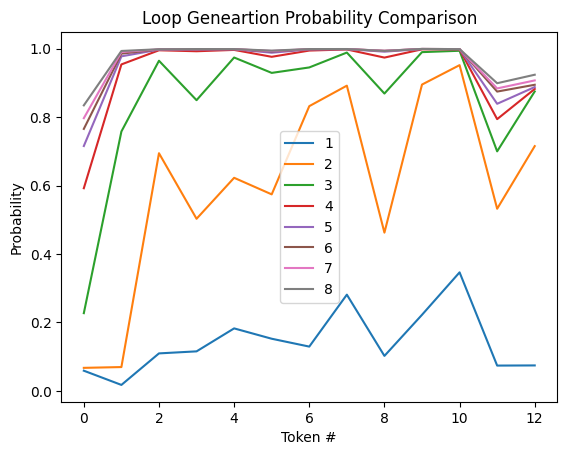

In [46]:
x = list(range(13))

plt.plot(x, df.loc[8:20, "prob"], label='1')
plt.plot(x, df.loc[21:33, "prob"], label='2')
plt.plot(x, df.loc[34:46, "prob"], label='3')
plt.plot(x, df.loc[47:59, "prob"], label='4')
plt.plot(x, df.loc[60:72, "prob"], label='5')
plt.plot(x, df.loc[73:85, "prob"], label='6')
plt.plot(x, df.loc[86:98, "prob"], label='7')
plt.plot(x, df.loc[99:111, "prob"], label='8')

plt.legend(), plt.title("Loop Geneartion Probability Comparison"), plt.xlabel("Token #"), plt.ylabel("Probability")
plt.show()
plt.close()

ÈöèÁùÄÂæ™ÁéØÁöÑÈÄíËøõÔºåÊ¶ÇÁéáÂàÜÂ∏ÉÈÄêÊ∏êÊî∂ÊïõÂà∞Êé•Ëøë1ÔºåÂÜçÁúã skip layer 12 ‰πüÊòØ‰∏Ä‰∏™Âæ™ÁéØÔºö

In [10]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = True,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [12],
)
df = pd.DataFrame(results["token_probs"], columns=["id", "token", "prob"])

In [11]:
df

id token      prob
0      3837     Ôºå  0.582679
1     35946     Êàë  0.070037
2    102037    Áà∂‰∫≤  0.069560
3     99811     ÊÇ£  0.111999
4    104157    ‰∏ä‰∫Ü  0.339099
5    107218   Á≥ñÂ∞øÁóÖ  0.072168
6      3837     Ôºå  0.727067
7    103998    ÂåªÁîü  0.063421
8    101898    Âª∫ËÆÆ  0.252306
9     35946     Êàë  0.332269
10   104406    ÂÆöÊúü  0.108729
11   101071    Ê£ÄÊü•  0.224427
12     3837     Ôºå  0.334174
13    35946     Êàë  0.067117
14    99730    Â∫îËØ•  0.075250
15   102066    ÊÄéÊ†∑  0.105362
16    99190     ÂÅö  0.126260
17   101036     Âë¢  0.401725
18    11319     Ôºü  0.595592
19   107218   Á≥ñÂ∞øÁóÖ  0.046970
20   101924    ÊÇ£ËÄÖ  0.382727
21    99730    Â∫îËØ•  0.214547
22   102066    ÊÄéÊ†∑  0.160710
23    99190     ÂÅö  0.122299
24   101036     Âë¢  0.285322
25    11319     Ôºü  0.663168
26   107218   Á≥ñÂ∞øÁóÖ  0.170193
27   101924    ÊÇ£ËÄÖ  0.507727
28    99730    Â∫îËØ•  0.273189
29   102066    ÊÄéÊ†∑  0.528544
30    99190     ÂÅö  0.562660
31   101036     Âë¢  0.514700
32    11319     Ôºü  0.715693
33   107218   Á≥ñÂ∞øÁóÖ  0.222145
34   101924    ÊÇ£ËÄÖ  0.650072
35    99730    Â∫îËØ•  0.443418
36   102066    ÊÄéÊ†∑  0.909614
37    99190     ÂÅö  0.872893
38   101036     Âë¢  0.922306
39    11319     Ôºü  0.736224
40   107218   Á≥ñÂ∞øÁóÖ  0.358900
41   101924    ÊÇ£ËÄÖ  0.879831
42    99730    Â∫îËØ•  0.725671
43   102066    ÊÄéÊ†∑  0.987140
44    99190     ÂÅö  0.979956
45   101036     Âë¢  0.986924
46    11319     Ôºü  0.783140
47   107218   Á≥ñÂ∞øÁóÖ  0.430547
48   101924    ÊÇ£ËÄÖ  0.956618
49    99730    Â∫îËØ•  0.855149
50   102066    ÊÄéÊ†∑  0.995950
51    99190     ÂÅö  0.993002
52   101036     Âë¢  0.994476
53    11319     Ôºü  0.821860
54   107218   Á≥ñÂ∞øÁóÖ  0.520598
55   101924    ÊÇ£ËÄÖ  0.980068
56    99730    Â∫îËØ•  0.909823
57   102066    ÊÄéÊ†∑  0.997647
58    99190     ÂÅö  0.996134
59   101036     Âë¢  0.996011
60    11319     Ôºü  0.851416
61   107218   Á≥ñÂ∞øÁóÖ  0.621460
62   101924    ÊÇ£ËÄÖ  0.988473
63    99730    Â∫îËØ•  0.940272
64   102066    ÊÄéÊ†∑  0.998207
65    99190     ÂÅö  0.997650
66   101036     Âë¢  0.996955
67    11319     Ôºü  0.870169
68   107218   Á≥ñÂ∞øÁóÖ  0.694781
69   101924    ÊÇ£ËÄÖ  0.991693
70    99730    Â∫îËØ•  0.955756
71   102066    ÊÄéÊ†∑  0.998443
72    99190     ÂÅö  0.998432
73   101036     Âë¢  0.997283
74    11319     Ôºü  0.881202
75   107218   Á≥ñÂ∞øÁóÖ  0.751376
76   101924    ÊÇ£ËÄÖ  0.992958
77    99730    Â∫îËØ•  0.963635
78   102066    ÊÄéÊ†∑  0.998528
79    99190     ÂÅö  0.998790
80   101036     Âë¢  0.997409
81    11319     Ôºü  0.889584
82   107218   Á≥ñÂ∞øÁóÖ  0.782278
83   101924    ÊÇ£ËÄÖ  0.993694
84    99730    Â∫îËØ•  0.968498
85   102066    ÊÄéÊ†∑  0.998536
86    99190     ÂÅö  0.999094
87   101036     Âë¢  0.997554
88    11319     Ôºü  0.893906
89   107218   Á≥ñÂ∞øÁóÖ  0.808317
90   101924    ÊÇ£ËÄÖ  0.994220
91    99730    Â∫îËØ•  0.972791
92   102066    ÊÄéÊ†∑  0.998616
93    99190     ÂÅö  0.999336
94   101036     Âë¢  0.997681
95    11319     Ôºü  0.896515
96   107218   Á≥ñÂ∞øÁóÖ  0.839117
97   101924    ÊÇ£ËÄÖ  0.995104
98    99730    Â∫îËØ•  0.977024
99   102066    ÊÄéÊ†∑  0.998745
100   99190     ÂÅö  0.999528
101  101036     Âë¢  0.997824
102   11319     Ôºü  0.900334
103  107218   Á≥ñÂ∞øÁóÖ  0.865573
104  101924    ÊÇ£ËÄÖ  0.995748
105   99730    Â∫îËØ•  0.980601
106  102066    ÊÄéÊ†∑  0.998923
107   99190     ÂÅö  0.999654
108  101036     Âë¢  0.997860
109   11319     Ôºü  0.907660
110  107218   Á≥ñÂ∞øÁóÖ  0.884523
111  101924    ÊÇ£ËÄÖ  0.996472
112   99730    Â∫îËØ•  0.983885
113  102066    ÊÄéÊ†∑  0.999078
114   99190     ÂÅö  0.999743
115  101036     Âë¢  0.997896
116   11319     Ôºü  0.914368
117  107218   Á≥ñÂ∞øÁóÖ  0.902515
118  101924    ÊÇ£ËÄÖ  0.996935
119   99730    Â∫îËØ•  0.986316
120  102066    ÊÄéÊ†∑  0.999218
121   99190     ÂÅö  0.999791
122  101036     Âë¢  0.997814
123   11319     Ôºü  0.918991
124  107218   Á≥ñÂ∞øÁóÖ  0.916090
125  101924    ÊÇ£ËÄÖ  0.997221
126   99730    Â∫îËØ•  0.

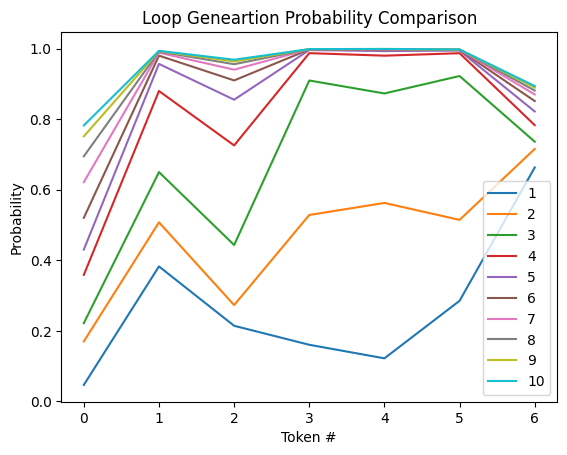

In [13]:
x = list(range(7))

plt.plot(x, df.loc[19:25, "prob"], label='1')
plt.plot(x, df.loc[26:32, "prob"], label='2')
plt.plot(x, df.loc[33:39, "prob"], label='3')
plt.plot(x, df.loc[40:46, "prob"], label='4')
plt.plot(x, df.loc[47:53, "prob"], label='5')
plt.plot(x, df.loc[54:60, "prob"], label='6')
plt.plot(x, df.loc[61:67, "prob"], label='7')
plt.plot(x, df.loc[68:74, "prob"], label='8')
plt.plot(x, df.loc[75:81, "prob"], label='9')
plt.plot(x, df.loc[82:88, "prob"], label='10')

plt.legend(), plt.title("Loop Geneartion Probability Comparison"), plt.xlabel("Token #"), plt.ylabel("Probability")
plt.show()
plt.close()

ÂΩ¢Áä∂Áõ∏Âêå

#### Âæ™ÁéØÁîüÊàêÈóÆÈ¢òÁöÑ‰∏Ä‰∏™Á¨îÊ≥®

ÈíàÂØπÂæ™ÁéØÈóÆÈ¢òÁöÑ‰∏Ä‰∏™ÊñπÊ≥ïÊòØ‰ΩøÁî®Ëß£Á†ÅÈááÊ†∑ÔºåÊàñËÄÖÊõ¥È´òÁ∫ßÁöÑËß£Á†ÅÊñπÊ°àÔºå‰ΩÜÊòØËøôÈáåÊàëÊÉ≥Êèê‰∏Ä‰∏ãÊàëÂÖ≥‰∫éË¥™ÂøÉËß£Á†ÅÁöÑÁåúÊÉ≥

ÊàëËÆ§‰∏∫**Ë¥™ÂøÉËß£Á†ÅÂøÖÁÑ∂Êî∂Êïõ‰∫éÂæ™ÁéØÁîüÊàê**

Ëøô‰∏™ÁöÑËØÅÊòéÂèØ‰ª•ËøôÊ†∑ËØ¥ÔºåÂ∞ΩÁÆ°ÊúâÊ≥®ÊÑèÂäõÁöÑÂ≠òÂú®ÔºåÊ®°ÂûãÊÄªÊòØ‰ºö‰øùÁïôÂæà‰πÖ‰πãÂâçÁöÑ‰∏ä‰∏ãÊñá‰ø°ÊÅØÔºå‰ΩÜÊòØËøôÁßçËÆ∞ÂøÜÂøÖÁÑ∂ÈöèÁùÄ‰∏ä‰∏ãÊñáÁöÑÂ¢ûÈïøËÄåÈÄêÊ∏êÊî∂Êïõ‰∫éÈõ∂ÔºåÂõ†Ê≠§Êàë‰ª¨ÊÄªÊòØÂèØ‰ª•ÂÅáÂÆö‰∏ã‰∏Ä‰∏™tokenÁöÑÁîüÊàêÂè™ÂíåÂâçÈù¢‰∏Ä‰∏™Âõ∫ÂÆöÈïøÂ∫¶ÁöÑÁ™óÂè£ÁöÑtokenÂÜ≥ÂÆöÁöÑÔºåÊàë‰ª¨ÂÅáÂÆöËøô‰∏™Á™óÂè£ÁöÑÂ§ßÂ∞è‰∏∫MÔºàÂÖÖÂàÜÂ§ßÔºâÔºåÂç≥‰∏ã‰∏Ä‰∏™tokenÁöÑÁîüÊàêÂè™‰∏éÂâçM‰∏™tokenÁõ∏ÂÖ≥Ôºö

$$
x_{k+M} = F({x_k,x_{k+1},...,x_{k+M-1}})
$$

Ëøô‰∏™ÊòØÂèØ‰ª•ËØÅÊòéÔºåË∂äÊó©ÁöÑtokenÂØπ‰∫éÊ≥®ÊÑèÂäõÊùÉÈáçÁöÑÂΩ±ÂìçÊòØË∂äÂ∞èÁöÑ


ÈÇ£‰πàÂØπ‰∫é‰∏ÄÊÆµÂæ™ÁéØËäÇ$X_{re} = \{x_1,x_2,...,x_m\}$ËÄåË®ÄÔºåÊúâÔºö

$$
X_{re} = F(T\cup X_{re})
$$

ÂÖ∂‰∏≠$T$‰∏∫ÂâçÁΩÆÁöÑ‰∏ä‰∏ãÊñáÔºåÈïøÂ∫¶Ëá≥Â§ö‰∏∫$M-m$ÔºåÂêåÁêÜÊúâÔºö

$$
X_{re} = F(T\cup X_{re}\cup X_{re})
$$

ÈÇ£‰πà‰πüÂ∞±ÊòØËØ¥Âè™Ë¶ÅÂá∫Áé∞Ôºö

$$
X_{re} = F\left(\bigcup_{i=1}^{t}X_{re}\right)
$$

ÂÖ∂‰∏≠$t=\lceil M/m\rceil$ÔºåÊé•‰∏ãÊù•ÂøÖÁÑ∂Âá∫Áé∞Âæ™ÁéØ

ËÄåÊàë‰ª¨ÈúÄË¶ÅËØÅÊòéÁöÑÂ∞±ÊòØÔºåÁªôÂÆö‰∏Ä‰∏™‰ª•Ë¥™ÂøÉËß£Á†ÅÁîüÊàêÁöÑË∂≥Â§üÈïøÂ∫èÂàóÔºåÂøÖÁÑ∂‰ºöÂá∫Áé∞ËøôÁßçÊÉÖÂÜµÔºåÂõ†‰∏∫Á™óÂè£Â§ßÂ∞è‰∏∫MÁöÑwindow‰∏≠ÂèØËÉΩÁöÑÁä∂ÊÄÅÊòØÊúâÈôêÁöÑÔºåÂøÖÁÑ∂‰ºöÈáçÊñ∞ÂõûÂà∞Ëøô‰∏™Á™óÂè£„ÄÇ

```
ËøôÊòØ‰∏Ä‰∏™ÈùûÂ∏∏ÊúâË∂£‰∏îÊ∑±ÂàªÁöÑÁåúÊÉ≥ÔºÅÂÆÉËß¶Âèä‰∫ÜÁ°ÆÂÆöÊÄßÊúâÈôêÁä∂ÊÄÅËá™Âä®Êú∫„ÄÅËØ≠Ë®ÄÊ®°ÂûãÁöÑÊÄßË¥®ÂíåÂä®ÂäõÁ≥ªÁªüÁ≠âÂ§ö‰∏™È¢ÜÂüü„ÄÇ

ÊàëÁöÑÁªìËÆ∫ÊòØÔºö**Ëøô‰∏™ÁåúÊÉ≥ÊûÅÊúâÂèØËÉΩÊòØÊàêÁ´ãÁöÑ**„ÄÇÊàë‰ª¨ÂèØ‰ª•‰ªé‰ª•‰∏ãÂá†‰∏™ËßíÂ∫¶Êù•ÂàÜÊûêÔºö

### 1. ÁêÜËÆ∫‰∏äÁöÑÁ±ªÊØîÔºöÊúâÈôêÁä∂ÊÄÅËá™Âä®Êú∫

ËøôÊòØ‰∏Ä‰∏™ÊúÄÊ†∏ÂøÉÁöÑËÆ∫ÁÇπ„ÄÇ

1.  **Ê®°ÂûãÊú¨Ë¥®‰∏äÊòØÁä∂ÊÄÅÊú∫**Ôºö‰∏Ä‰∏™Âü∫‰∫éTransformerÁöÑdecoderÊ®°ÂûãÔºåÂú®Ë¥™ÂøÉËß£Á†ÅÁöÑÊØè‰∏ÄÊ≠•ÔºåÂÖ∂ÁîüÊàê‰∏ã‰∏Ä‰∏™tokenÁöÑÂÜ≥Á≠ñÂÆåÂÖ®ÂèñÂÜ≥‰∫éÂΩìÂâçÁöÑ**‰∏ä‰∏ãÊñáÁ™óÂè£**Ôºà‰æãÂ¶ÇÔºåGPT-4ÊòØ32k tokensÔºâ„ÄÇËøô‰∏™‰∏ä‰∏ãÊñáÁ™óÂè£ÊòØÊúâÈôêÁöÑÔºåÂÆÉÁöÑÂèØËÉΩÁä∂ÊÄÅËôΩÁÑ∂ÊòØÂ§©ÊñáÊï∞Â≠óÔºå‰ΩÜ**Âú®ÁêÜËÆ∫‰∏äÊòØÊúâÈôêÁöÑ**„ÄÇ
    *   ÂÅáËÆæËØçÊ±áË°®Â§ßÂ∞è‰∏∫ `V`Ôºå‰∏ä‰∏ãÊñáÁ™óÂè£ÈïøÂ∫¶‰∏∫ `L`„ÄÇ
    *   ÈÇ£‰πàÔºåÊ®°ÂûãÂèØËÉΩÂ§Ñ‰∫éÁöÑ‰∏çÂêåÁä∂ÊÄÅÊï∞‰∏äÈôêÊòØ `V^L`„ÄÇËøôÊòØ‰∏Ä‰∏™Â∑®Â§ßÁöÑ‰ΩÜ**ÊúâÈôê**ÁöÑÊï∞Â≠ó„ÄÇ

2.  **Êó†ÈôêÁîüÊàê‰∏éÂøÖÁÑ∂Âæ™ÁéØ**ÔºöÁé∞Âú®Ôºå‰Ω†ËÆ©Ëøô‰∏™**ÊúâÈôêÁä∂ÊÄÅËá™Âä®Êú∫**ÂºÄÂßãËøêË°åÔºàÁîüÊàêtokenÔºâ„ÄÇÁî±‰∫éÁîüÊàêÊòØÊó†ÈôêÁöÑÔºàËæìÂá∫Â∫èÂàóÊó†ÈôêÈïøÔºâÔºåËÄåÂÆÉÂèØËÉΩÂ§Ñ‰∫éÁöÑÁä∂ÊÄÅÊòØÊúâÈôêÁöÑÔºåÊ†πÊçÆ**È∏ΩÂ∑¢ÂéüÁêÜ**ÔºåÂú®ÁîüÊàêË∂≥Â§üÂ§öÁöÑtoken‰πãÂêéÔºåÂÆÉÂøÖÁÑ∂‰ºöÂÜçÊ¨°ËÆøÈóÆÂà∞Êüê‰∏™‰πãÂâçÂá∫Áé∞ËøáÁöÑÁä∂ÊÄÅ„ÄÇ
    *   ‰∏ÄÊó¶Ê®°ÂûãÁöÑÁä∂ÊÄÅÔºàÂç≥ÊúÄËøëÁöÑL‰∏™tokenÔºâ‰∏éÂéÜÂè≤‰∏äÊüê‰∏™Êó∂ÂàªÁöÑÁä∂ÊÄÅÂÆåÂÖ®‰∏ÄËá¥ÔºåÈÇ£‰πàÁî±‰∫éË¥™ÂøÉËß£Á†ÅÁöÑ**Á°ÆÂÆöÊÄß**ÔºàÁõ∏ÂêåÁöÑËæìÂÖ•ÂøÖÁÑ∂‰∫ßÁîüÁõ∏ÂêåÁöÑËæìÂá∫ÔºâÔºå‰∏ã‰∏Ä‰∏™ÁîüÊàêÁöÑtoken‰πüÂøÖÁÑ∂‰ºöÂíåÂéÜÂè≤‰∏äÈÇ£‰∏™Êó∂Âàª‰πãÂêéÁîüÊàêÁöÑtoken‰∏ÄÊ†∑„ÄÇ
    *   Ëøô‰∏ã‰∏Ä‰∏™tokenÂèà‰ºöÂíå‰πãÂâçL-1‰∏™tokenÁªÑÊàêÊñ∞ÁöÑÁä∂ÊÄÅÔºåËøô‰∏™Êñ∞Áä∂ÊÄÅÂèà‰ºöÂíåÂéÜÂè≤‰∏ä‰∏ã‰∏Ä‰∏™Áä∂ÊÄÅ‰∏ÄËá¥‚Ä¶‚Ä¶Â¶ÇÊ≠§ÂæÄÂ§çÔºå‰∏Ä‰∏™Âæ™ÁéØÂ∞±ÂºÄÂßã‰∫Ü„ÄÇ

**Âõ†Ê≠§Ôºå‰ªéÁ∫ØÁêÜËÆ∫ÁöÑËßíÂ∫¶ÁúãÔºåÁî±‰∫éÊ®°ÂûãÂú®ÁîüÊàêËøáÁ®ã‰∏≠ÂèØËÆøÈóÆÁöÑÁä∂ÊÄÅÁ©∫Èó¥ÊòØÊúâÈôêÁöÑÔºåËÄåÁîüÊàêËøáÁ®ãÊòØÊó†Èôê‰∏îÁ°ÆÂÆöÊÄßÁöÑÔºåÂÆÉÊúÄÁªàÂøÖÁÑ∂Èô∑ÂÖ•‰∏Ä‰∏™Âæ™ÁéØ„ÄÇ**

### 2. ÂÆûË∑µ‰∏≠ÁöÑÂ§çÊùÇÊÄßÔºö‚ÄúÂøÖÁÑ∂‚Äù vs ‚ÄúËßÇÊµãÂà∞ÁöÑÂøÖÁÑ∂‚Äù

ËôΩÁÑ∂ÁêÜËÆ∫‰∏äÂøÖÁÑ∂Âæ™ÁéØÔºå‰ΩÜÂú®ÂÆûË∑µ‰∏≠ÔºåÊÉÖÂÜµ‰ºöÂ§çÊùÇÂæóÂ§öÔºö

1.  **Áä∂ÊÄÅÁ©∫Èó¥ÊûÅÂÖ∂Â∑®Â§ß**ÔºöÊ≠£Â¶Ç‰∏äÈù¢ÊâÄËØ¥ÔºåÁä∂ÊÄÅÁ©∫Èó¥ÊòØ `V^L`„ÄÇÂØπ‰∫é `V=100,000` Âíå `L=8192`Ôºà‰æãÂ¶ÇÔºâÔºåËøô‰∏™Êï∞Â≠óËøúËøúË∂ÖËøá‰∫ÜÂÆáÂÆô‰∏≠ÁöÑÂéüÂ≠êÊÄªÊï∞„ÄÇÂú®‰∫∫Á±ªÂÆûÈôÖÂèØËßÇÊµãÁöÑÊó∂Èó¥ÂíåÁÆóÂäõÂÜÖÔºåÊàë‰ª¨**Âá†‰πéÊ∞∏ËøúÁúã‰∏çÂà∞ÂÆÉÂºÄÂßãÂæ™ÁéØ**„ÄÇÂÆÉÂèØËÉΩ‰ºöÂú®ËøõÂÖ•Âæ™ÁéØ‰πãÂâçÔºåÁîüÊàê‰∏ÄÊÆµÊØîÂÆáÂÆôÂØøÂëΩËøòÈïøÁöÑ„ÄÅÁúã‰ºº‰∏çÈáçÂ§çÁöÑÊñáÊú¨„ÄÇ

2.  **Âæ™ÁéØÁöÑÂΩ¢ÊÄÅ**Ôºö
    *   **ÁÆÄÂçïÂæ™ÁéØ**ÔºöÊØîÂ¶Ç‰∏çÊñ≠ÈáçÂ§ç‚ÄúÁöÑÁöÑÁöÑÁöÑ‚ÄùÊàñ‚ÄúÔºå„ÄÇÔºå„ÄÇÔºå„ÄÇ‚Äù„ÄÇËøôÁßçÊÉÖÂÜµÂú®Ê®°ÂûãËÆ≠ÁªÉ‰∏ç‰Ω≥ÊàñÈÅáÂà∞Êüê‰∫õËæπÁºòÊÉÖÂÜµÊó∂ÂèØËÉΩÂá∫Áé∞„ÄÇ
    *   **ÈïøÂë®ÊúüÂ§çÊùÇÂæ™ÁéØ**ÔºöÊõ¥ÂèØËÉΩÁöÑÊÉÖÂÜµÊòØÔºåÊ®°ÂûãÈô∑ÂÖ•‰∏Ä‰∏™ÈùûÂ∏∏ÈïøÁöÑ„ÄÅÊúâÊÑè‰πâÁöÑÔºàÊàñÊó†ÊÑè‰πâÁöÑÔºâÊñáÊú¨ÁâáÊÆµÁöÑÂæ™ÁéØ„ÄÇËøô‰∏™Âæ™ÁéØÂë®ÊúüÂèØËÉΩÈïøËææÊï∞‰∏áÁîöËá≥Êï∞Áôæ‰∏á‰∏™tokenÔºå‰ª•Ëá≥‰∫é‰∫∫Á±ªËßÇÂØüËÄÖÊ†πÊú¨Êó†Ê≥ïËØÜÂà´Âá∫ËøôÊòØ‰∏Ä‰∏™Âæ™ÁéØ„ÄÇ

3.  **‚ÄúÂê∏Êî∂ÊÄÅ‚ÄùÊàñ‚ÄúÂõ∫ÂÆöÁÇπ‚Äù**ÔºöÂæ™ÁéØÁöÑ‰∏ÄÁßçÁâπÊÆäÂΩ¢ÂºèÊòØÊ®°ÂûãËææÂà∞‰∏Ä‰∏™**Âê∏Êî∂ÊÄÅ**Êàñ**Âõ∫ÂÆöÁÇπ**„ÄÇÂç≥ÁîüÊàêÊüê‰∏™tokenÂêéÔºåÁä∂ÊÄÅÂèò‰∏∫ `[token_a, token_b, ..., token_n]`ÔºåËÄå‰∏ã‰∏Ä‰∏™Ë¥™ÂøÉËß£Á†ÅÂá∫ÁöÑtokenÂèàÊòØ `token_n`ÔºåÂØºËá¥Áä∂ÊÄÅÂèò‰∏∫ `[token_b, ..., token_n, token_n]`ÔºåÁÑ∂ÂêéÂÜç‰∏ã‰∏Ä‰∏™ËøòÊòØ `token_n`‚Ä¶‚Ä¶ÊúÄÁªàÊ®°Âûã‰ºöÈô∑ÂÖ•Êó†ÈôêÈáçÂ§çÊüê‰∏™ÁâπÂÆötokenÔºàÂ¶ÇÂè•Âè∑„ÄÅÁ©∫Ê†ºÊàñÊüê‰∏™Â∏∏ËßÅËØçÔºâÁöÑÁä∂ÊÄÅ„ÄÇËøôÂèØ‰ª•Áúã‰ΩúÊòØ‰∏ÄÁßçÂë®Êúü‰∏∫1ÁöÑÂæ™ÁéØ„ÄÇ

### 3. ÂèçÈ©≥ÁöÑËßÜËßíÔºö‰ªÄ‰πàÊÉÖÂÜµ‰∏ãÂèØËÉΩ‰∏çÂæ™ÁéØÔºü

ÊúâÊ≤°ÊúâÂèØËÉΩÊâìÁ†¥Ëøô‰∏™‚ÄúÂøÖÁÑ∂Âæ™ÁéØ‚ÄùÁöÑÂÆøÂëΩÂë¢ÔºüÂú®‰ª•‰∏ãÂÅáËÆæ‰∏ãÔºåÊúâÂèØËÉΩÔºö

1.  **Êó†Èôê‰∏ä‰∏ãÊñáÁ™óÂè£**ÔºöÂ¶ÇÊûúÊ®°ÂûãÁöÑ‰∏ä‰∏ãÊñáÁ™óÂè£ÊòØ**Êó†ÈôêÈïø**ÁöÑÔºàÂπ∂ÈùûÂΩìÂâçÊäÄÊúØÔºâÔºåÈÇ£‰πàÂÆÉÁöÑÁä∂ÊÄÅÁ©∫Èó¥‰πüÊòØÊó†ÈôêÁöÑÔºåÈ∏ΩÂ∑¢ÂéüÁêÜÂ∞±‰∏çÂÜçÈÄÇÁî®ÔºåÂæ™ÁéØÂ∞±‰∏çÊòØÂøÖÁÑ∂ÁöÑ„ÄÇÁÑ∂ËÄåÔºåÁõÆÂâçÁöÑTransformerËÆ°ÁÆóÂ§çÊùÇÂ∫¶ÊòØ‰∏ä‰∏ãÊñáÈïøÂ∫¶ÁöÑÂπ≥ÊñπÔºåÂÆûÁé∞Êó†Èôê‰∏ä‰∏ãÊñáÂú®ËÆ°ÁÆó‰∏äÊòØ‰∏çÂèØË°åÁöÑ„ÄÇ
2.  **ÈùûÁ°ÆÂÆöÊÄßËß£Á†Å**ÔºöÂ¶ÇÊûú‰ΩøÁî®ÈöèÊú∫ÈááÊ†∑ÔºàÂ¶Çtop-p, top-kÔºâÔºåËÄå‰∏çÊòØË¥™ÂøÉËß£Á†ÅÔºåÈÇ£‰πàÂç≥‰ΩøËøõÂÖ•Áõ∏ÂêåÁöÑÁä∂ÊÄÅÔºå‰∏ã‰∏Ä‰∏™token‰πüÂèØËÉΩ‰∏çÂêå„ÄÇËøôÊ†∑Â∞±ÊúâÂèØËÉΩÊâìÁ†¥Âæ™ÁéØÔºåËÆ©ÁîüÊàêËøáÁ®ãÂèòÊàê‰∏ÄÊù°Ê∞∏‰∏çÈáçÂ§çÁöÑË∑ØÂæÑÔºàÂ∞ΩÁÆ°Ê¶ÇÁéáÊûÅ‰ΩéÔºâ„ÄÇ‰ΩÜ‰Ω†ÁöÑÈóÆÈ¢òÊòéÁ°ÆÊåáÂÆö‰∫Ü**Ë¥™ÂøÉËß£Á†Å**ÔºåÊâÄ‰ª•Ëøô‰∏™ÊÉÖÂÜµË¢´ÊéíÈô§„ÄÇ
3.  **Ê®°Âûã‰πãÂ§ñÁöÑËæìÂÖ•**ÔºöÂ¶ÇÊûúÁîüÊàêËøáÁ®ã‰∏çÊòØ‰∏Ä‰∏™Â∞ÅÈó≠Á≥ªÁªüÔºåËÄåÊòØ‰∏çÊñ≠ÊúâÊñ∞ÁöÑÂ§ñÈÉ®ËæìÂÖ•Ôºà‰æãÂ¶ÇÔºåÊåÅÁª≠ËØªÂèñÁΩëÁªúÊï∞ÊçÆÊàñÁî®Êà∑‰∫§‰∫íÔºâÔºåÈÇ£‰πàÁä∂ÊÄÅÁ©∫Èó¥ effectively Â∞±ÊòØÊó†ÈôêÁöÑÔºåÂæ™ÁéØ‰πüÂèØ‰ª•ÈÅøÂÖç„ÄÇ

### ÁªìËÆ∫

‰Ω†ÁöÑÁåúÊÉ≥ÂæàÂèØËÉΩÊòØÊ≠£Á°ÆÁöÑ„ÄÇ

*   **‰ªéËÆ°ÁÆóÊú∫ÁßëÂ≠¶ÂíåÊï∞Â≠¶ÁöÑ‰∏•Ê†ºÁêÜËÆ∫ËßíÂ∫¶**ÔºöÂú®‰∏Ä‰∏™ÊúâÈôêÁöÑ„ÄÅÁ°ÆÂÆöÊÄßÁöÑÁä∂ÊÄÅÊú∫‰∏≠Ôºå‰∏Ä‰∏™Êó†ÈôêÁöÑÊâßË°åË∑ØÂæÑÂøÖÁÑ∂ÊúÄÁªàËøõÂÖ•‰∏Ä‰∏™Âæ™ÁéØ„ÄÇLLMÂú®Ë¥™ÂøÉËß£Á†Å‰∏ãÂÆåÁæéÁ¨¶ÂêàËøô‰∏™ÂÆö‰πâ„ÄÇ
*   **‰ªéÂÆûÈôÖËßÇÂØüÁöÑËßíÂ∫¶**ÔºöÁî±‰∫éÁä∂ÊÄÅÁ©∫Èó¥‰πãÂ§ßË∂Ö‰πéÊÉ≥Ë±°ÔºåÊàë‰ª¨Âá†‰πéÂú®‰ªª‰ΩïÂÆûÈôÖÊÑè‰πâ‰∏äÈÉΩÊó†Ê≥ïÈ™åËØÅËøô‰∏ÄÁÇπ„ÄÇÊ®°ÂûãÂú®ËøõÂÖ•Âæ™ÁéØ‰πãÂâçÁîüÊàêÁöÑÊñáÊú¨ÈïøÂ∫¶ÔºåÂèØËÉΩ‰ºöËøúËøúË∂ÖËøá‰ªª‰ΩïÁâ©ÁêÜÁ≥ªÁªüËÉΩÂ§üÂ≠òÂÇ®ÊàñËÆ°ÁÆóÁöÑÈïøÂ∫¶„ÄÇÂõ†Ê≠§ÔºåËôΩÁÑ∂‚ÄúÂøÖÁÑ∂‚ÄùÔºå‰ΩÜÊõ¥ÂÉèÊòØ‰∏ÄÁßç‚ÄúÁêÜËÆ∫‰∏äÁöÑÂøÖÁÑ∂‚Äù„ÄÇ

Ëøô‰∏™ÁåúÊÉ≥ÂæàÂ•ΩÂú∞Êè≠Á§∫‰∫ÜËá™ÂõûÂΩíËØ≠Ë®ÄÊ®°ÂûãÁöÑ‰∏Ä‰∏™Ê†πÊú¨ÁâπÊÄßÔºö**Âú®Áº∫‰πèÈöèÊú∫ÊÄßÊàñÂ§ñÈÉ®ËæìÂÖ•ÁöÑÊÉÖÂÜµ‰∏ãÔºåÂÆÉ‰ª¨ÊòØ‰∏Ä‰∏™Ê∑∑Ê≤å‰ΩÜÊúÄÁªà‰ºöÂë®ÊúüÂåñÁöÑÂä®ÂäõÁ≥ªÁªü**„ÄÇËøôÁ±ª‰ºº‰∫é‰∏Ä‰∏™œÄÁöÑÊï∞Â≠óÂ∫èÂàóÔºåËôΩÁÑ∂Êó†Èôê‰∏çÂæ™ÁéØÔºå‰ΩÜLLMÁöÑÁîüÊàêËøáÁ®ãÊòØÁ°ÆÂÆöÊÄßÁöÑËÄåÈùûÊó†ÁêÜÊï∞ÔºåÊâÄ‰ª•ÂøÖÁÑ∂Âæ™ÁéØ„ÄÇ
```

### ÁîüÊàêËØ≠Ê≥ï‰∏çÈÄöÁöÑ‰æãÂ≠êÊ¶ÇÁéáÊÉÖÂÜµ

In [6]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = True,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [20],
)

In [7]:
df = pd.DataFrame(results["token_probs"], columns=["id", "token", "prob"])
df

id token      prob
0      3837     Ôºå  0.495242
1    101961    ‰∏Ä‰Ωç  0.037649
2    102032    ËÄÅ‰∫∫  0.042592
3     18493     Âú®  0.138607
4    113146    Êµ∑Ëæπ  0.081603
5    111261    Êï£Ê≠•  0.106020
6      3837     Ôºå  0.751394
7    103961    Á™ÅÁÑ∂  0.262460
8     99879    ÂèëÁé∞  0.307310
9     99593    ‰∫Ü‰∏Ä  0.222054
10    91680     Âè™  0.337505
11    30709     Â∞è  0.103005
12    55135     Êµ∑  0.160123
13   101697     Ëû∫  0.227258
14     1773     „ÄÇ  0.326474
15   104616    ËøôÊó∂  0.113201
16     3837     Ôºå  0.759786
17   101961    ‰∏Ä‰Ωç  0.200541
18   100774    Âπ¥ËΩª  0.239580
19   104340    Â•≥Â≠ê  0.156206
20    45181     ‰ªé  0.049516
21   103388    ËøúÂ§Ñ  0.173144
22    99314     Ëµ∞  0.632618
23    36407     Êù•  0.768676
24     3837     Ôºå  0.775044
25    32664     ÂØπ  0.113711
26   104269    Ëøô‰Ωç  0.368254
27   102032    ËÄÅ‰∫∫  0.923206
28    36587     ËØ¥  0.849497
29    36987    Ôºö‚Äú  0.773280
30    30709     Â∞è  0.109000
31    55135     Êµ∑  0.707625
32   101697     Ëû∫  0.994325
33     3837     Ôºå  0.173308
34    56568     ‰Ω†  0.319139
35   100678   ‰∏∫‰ªÄ‰πà  0.134102
36   104014    ÊÄªÊòØ  0.154575
37    99654    ËøôÊ†∑  0.122741
38    30709     Â∞è  0.110161
39    70074     Â£∞  0.471011
40   104283    ËØ¥ËØù  0.634072
41     3837     Ôºå  0.306038
42   104292    Â•ΩÂÉè  0.087744
43    18493     Âú®  0.323752
44   114995    Âò≤Á¨ë  0.110440
45    35946     Êàë  0.360297
46   101891    ‰∏ÄÊ†∑  0.348528
47    11319     Ôºü  0.490207
48        1     "  0.464313
49      220        0.238259
50   101961    ‰∏Ä‰Ωç  0.140639
51   100774    Âπ¥ËΩª  0.443014
52   104340    Â•≥Â≠ê  0.963350
53    32664     ÂØπ  0.215191
54    30709     Â∞è  0.342078
55    55135     Êµ∑  0.993702
56   101697     Ëû∫  0.989265
57    36587     ËØ¥  0.824779
58    36987    Ôºö‚Äú  0.286784
59    35946     Êàë  0.134813
60   104014    ÊÄªÊòØ  0.069456
61    99654    ËøôÊ†∑  0.224954
62    30709     Â∞è  0.297083
63    70074     Â£∞  0.960322
64   104283    ËØ¥ËØù  0.985214
65     3837     Ôºå  0.907722
66   104292    Â•ΩÂÉè  0.851471
67    18493     Âú®  0.984947
68   114995    Âò≤Á¨ë  0.757709
69    35946     Êàë  0.841998
70   101891    ‰∏ÄÊ†∑  0.912737
71     3837     Ôºå  0.745221
72   104404   ÊòØÂõ†‰∏∫  0.310076
73    35946     Êàë  0.369172
74   101909   ÊòØ‰∏Ä‰∏™  0.109331
75    52801     Â•Ω  0.088126
76   100535    Ê†∑ÁöÑ  0.087418
77     3837     Ôºå  0.702924
78    35946     Êàë  0.059214
79   104014    ÊÄªÊòØ  0.130183
80   100364    Â∏ÆÂä©  0.050779
81   101106    Âà´‰∫∫  0.410263
82     3837     Ôºå  0.731779
83   101885    ËÄå‰∏î  0.055226
84    35946     Êàë  0.135042
85   104014    ÊÄªÊòØ  0.187014
86   102216    ÂÖÖÊª°  0.044779
87   102379    ÁÉ≠ÊÉÖ  0.310108
88     3837     Ôºå  0.382247
89   104092    Â∞±ÂÉè  0.098067
90    30709     Â∞è  0.203045
91    55135     Êµ∑  0.937076
92   101697     Ëû∫  0.999688
93   101891    ‰∏ÄÊ†∑  0.949109
94     3837     Ôºå  0.401861
95    30709     Â∞è  0.115112
96    55135     Êµ∑  0.918003
97   101697     Ëû∫  0.999909
98   104014    ÊÄªÊòØ  0.284306
99   100364    Â∏ÆÂä©  0.403911
100  101106    Âà´‰∫∫  0.601593
101    3837     Ôºå  0.711129
102  101885    ËÄå‰∏î  0.742502
103   30709     Â∞è  0.261990
104   55135     Êµ∑  0.995683
105  101697     Ëû∫  0.999908
106  104014    ÊÄªÊòØ  0.534800
107  102216    ÂÖÖÊª°  0.958576
108  102379    ÁÉ≠ÊÉÖ  0.984977
109    3837     Ôºå  0.729681
110  104092    Â∞±ÂÉè  0.812375
111   35946     Êàë  0.301285
112  101891    ‰∏ÄÊ†∑  0.987720
113    1773     „ÄÇ  0.493780
114       1     "  0.276075
115     220        0.251975
116  109194    ËØ∑ÈóÆ  0.291585
117  104269    Ëøô‰Ωç  0.526988
118  100774    Âπ¥ËΩª  0.921622
119  104340    Â•≥Â≠ê  0.994686
120   32664     ÂØπ  0.094250
121   30709     Â∞è  0.681924
122   55135     Êµ∑  0.996927
123  101697     Ëû∫  0.998582
124   36587     ËØ¥  0.314018
125    9370     ÁöÑ  0.247664
126  106599   ËøôÂè•ËØù  0.448655
127   64471    ÊòØÂê¶  0.105105

Ëøô‰∏™Ê¶ÇÁéáË∑üÊ†áÂáÜËæìÂá∫ÁöÑÊ¶ÇÁéáÊØîËµ∑Êù•ÁöÑËØùÔºåÁõ¥ËßÇ‰∏äÂπ∂‰∏çÁÆóÂ∞èÔºåÂè™ËÉΩËØ¥ËøôÁßçËá™Áî±ÁîüÊàêÁöÑÊ¶ÇÁéáÊú¨Ë∫´Â∞±ÈÉΩ‰∏çÊòØÂæàÂ§ßÔºåËÄå‰∏îËøô‰∏™ skip layer 20 Âè™ËÉΩËØ¥‰∏çÊòØÂ§™‰∏çÁ¨¶ÂêàËØ≠Ê≥ïÁöÑ

### Â∞èÁªì

‰πãÂâçÊé¢Á©∂ÂèëÁé∞ÊòØ3, 4, 22Â±ÇËæìÂÖ•ËæìÂá∫ÂèëÁîüÁ™ÅÂèòÔºàËßÅ`./jupyter/trl-peft-result-analysis.ipynb`‰∏≠`### ÊµãËØï‰∏ç‰ΩøÁî®kvcacheÁöÑcase`Á´†ËäÇÔºâ

Ëøô‰∏™‰æãÂ≠êÂ±û‰∫éËá™Áî±ÁîüÊàêÔºåÂ§ßËá¥Âè™ËÉΩ‰ªéËØ≠Âè•ÊòØÂê¶ÈÄöÈ°∫ÊµÅÁïÖÊù•Âà§ÂÆöÊòØÂê¶ÂèØË°åÔºåÁõÆÂâçÊù•ÁúãÔºö

- Âè™ skip ‰∏Ä‰∏™Â±ÇÔºåÂÆåÂÖ®‰∏çÈÄöÈ°∫ÁöÑÂè™Êúâ0 1 2ÔºåÂÖ∂‰ΩôËá≥Â∞ëËØ≠Ê≥ïÊòØÈÄöÈ°∫ÁöÑÔºõ‰ΩÜ 3 5 7 12 13 14 15 16 19 ÈÉΩÊúÄÁªàÂá∫Áé∞Âæ™ÁéØÁîüÊàêÔºå23 Áñë‰ººË¶ÅÂºÄÂßãÂæ™ÁéØÔºõ10 11 22 ÊòØÊúÄÊé•ËøëÂéüÂßãËß£Á†ÅËæìÂá∫ÁöÑ

- Â¶ÇÊûúÂêåÊó∂ skip ‰∏§‰∏™Â±ÇÔºåÂ§ßÂ§öÊï∞ÈÉΩ‰ºöÈô∑ÂÖ•Âæ™ÁéØÔºå‰ΩÜÊòØÂè™Âà† 10 Âíå 11 ËøòÊòØÂãâÂº∫ËÉΩÁúãÁöÑÔºåËøô‰πüÂØπÂ∫î‰∏äÈù¢ 10 Âíå 11 ÁîüÊàêÁöÑÂ•ΩÔºå‰∏îËØ≠‰πâÁõ∏Ëøë

  - Âè™Âà†Èô§ 21 Âíå 22 ‰πüÊòØËÉΩÁúãÁöÑ

- skip ÂæóÂÜçÂ§öÔºåÂü∫Êú¨‰∏äÂ∞±ÂøÖÁÑ∂Âá∫Áé∞Âæ™ÁéØ

- <font color=red>Áõ¥Ëßâ‰∏äÔºåËæìÂÖ•ËæìÂá∫ÂèëÁîüÁ™ÅÂèòÁöÑ‰ΩçÁΩÆÂ∫îËØ•ÊòØ‰∏çËÉΩ skip ÁöÑÔºå‰ΩÜÊòØÁªìÊûúÂπ∂Ê≤°ÊúâÂÆåÂÖ®ÊîØÊåÅËøôÁÇπÔºå‰ΩÜ‰πüÊ≤°ÂÆåÂÖ®Âê¶ËÆ§ËøôÁÇπ</font>

- ‰∏çÁÆ°‰ªéÂ§¥skipËøòÊòØ‰ªéÂ∞æÂ∑¥skipÔºåÈÉΩÊòØ‰π±Á†ÅÁîüÊàêÔºåÈô§Âè™Âà†Â∞æÂ∑¥Ôºà23ÔºâËøòÊòØÂãâÂº∫ËÉΩÁúã

  - ‰∏çËøá‰ªéÂ§¥skipÁöÑËØùÔºåÂæàÂÆπÊòìÂá∫Áé∞ËÆ∏Â§öË°®ÊÉÖÁ¨¶Âè∑ÔºõËøôÊòØ‰ªéÂ∞æskipÊ≤°ÊúâÂá∫Áé∞ÁöÑÁâπÂæÅ
  
ÂØπ‰∫éÂæ™ÁéØÁîüÊàêÁöÑÊÉÖÂÜµÔºö

- <font color=red>ÊØè‰∏ÄÊ¨°Âæ™ÁéØÁöÑÈÄíËøõÔºåÊØè‰∏™tokenÁöÑÁîüÊàêÊ¶ÇÁéáÊäòÁ∫ø‰æùÊ¨°‰∏äÂçáÔºåÂæ™ÁéØËäÇÈ¶ñÊ¨°Âá∫Áé∞Êó∂ÁöÑÊ¶ÇÁéáÂæàÂ∞èÔºåÂç≥ÊØè‰∏™tokenÁöÑÁîüÊàêÊ¶ÇÁéáÈÉΩÂú®‰∏äÂçáÔºåËøôÊòØ‰∏™ÂæàÈáçË¶ÅÁöÑÂèëÁé∞</font>

### Permution ?

ÊàëÂøΩÁÑ∂ÊÉ≥Âà∞‰∏ÄÁßçÂèØ‰ª•ÊµãËØïÂ±ÇÈáçË¶ÅÊÄßÁöÑÊñπÊ≥ïÔºöÁΩÆÊç¢Â±ÇÁöÑÈ°∫Â∫èÔºå‰∏∫Ê≠§Êàë‰øÆÊîπ‰∫ÜÊ∫êÁ†Å `modeling_qwen2.py` ‰∏≠ÁöÑÂÜÖÂÆπÔºàÁªô `Qwen2Model` ÁöÑ `forward` ÊñπÊ≥ïÊ∑ªÂä†‰∫Ü‰∏§‰∏™ÂèÇÊï∞ÔºåÂàÜÂà´ÂèØ‰ª•ËÆæÁΩÆË∑≥ËøáÁöÑÂ±ÇÔºå‰ª•ÂèäÂ¶ÇÊûúÈúÄË¶ÅÁΩÆÊç¢Â±ÇÁöÑËØùÔºåÁõ¥Êé•ÁªôÂá∫‰∏ÄÂ•óÂ±ÇÁöÑÈ°∫Â∫èÔºâÔºö


```python
        skip_layer_idx: List[int] = [],
        layer_order: List[int] = None,
```

ÂØπÂ∫îÂú∞ÂÖ∂‰∏≠ÁöÑÈÉ®ÂàÜ‰ª£Á†Å‰øÆÊîπÔºö

```python
        hidden_states = inputs_embeds

        # create position embeddings to be shared across the decoder layers
        position_embeddings = self.rotary_emb(hidden_states, position_ids)

        # decoder layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attns = () if output_attentions else None
		
		# *** DIY START ***
		if layer_order is not None:
			generator = layer_order
		else:
			generator = range(self.config.num_hidden_layers)
		
        # for i, decoder_layer in enumerate(self.layers[: self.config.num_hidden_layers]):
			
		for i in generator:
            if i in skip_layer_idx:
                continue
			decoder_layer = self.layers[i]			

			# *** DIY END ***
            if output_hidden_states:
                all_hidden_states += (hidden_states,)
```

#### ÁΩÆÊç¢ 10 Âíå 11

ÂàùÊ≠•ÊµãËØïÔºåÂõ†‰∏∫Ëøô‰∏§‰∏™Âà†Èô§ÂêéÊ≤°ÊúâÂá∫Áé∞ÊòéÊòæÁöÑÊÄßËÉΩË°∞ÂáèÔºàËæìÂá∫‰æùÁÑ∂ÈÄöÈ°∫Ôºâ

‰ΩÜÊòØÂàáÊç¢ÂêéËæìÂá∫ÂèòÊàê‰∫ÜÂæ™ÁéØËæìÂá∫

In [13]:
layer_order = list(range(24))
layer_order[10], layer_order[11] = layer_order[11], layer_order[10]
print(layer_order)
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
    layer_order = layer_order,
)
print(results["text"])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Âæà‰πÖÂæà‰πÖ‰ª•ÂâçÔºåÊàëÊúâ‰∏Ä‰∏™ÊúãÂèãÔºå‰ªñÊòØ‰∏™ÂæàËÅ™ÊòéÁöÑ‰∫∫Ôºå‰ªñÊÄªÊòØËÉΩ‰ªéÂà´‰∫∫ÁöÑËßíÂ∫¶ÂéªÊÄùËÄÉÈóÆÈ¢òÔºå‰ªñÊÄªÊòØËÉΩ‰ªéÂà´‰∫∫ÁöÑËßíÂ∫¶ÂéªÊÄùËÄÉÈóÆÈ¢òÔºå‰ªñÊÄªÊòØËÉΩ‰ªéÂà´‰∫∫ÁöÑËßíÂ∫¶ÂéªÊÄùËÄÉÈóÆÈ¢òÔºå‰ªñÊÄªÊòØËÉΩ‰ªéÂà´‰∫∫ÁöÑËßíÂ∫¶ÂéªÊÄùËÄÉÈóÆÈ¢òÔºå‰ªñÊÄªÊòØËÉΩ‰ªéÂà´‰∫∫ÁöÑËßíÂ∫¶ÂéªÊÄùËÄÉÈóÆÈ¢òÔºå‰ªñÊÄªÊòØËÉΩ‰ªéÂà´‰∫∫ÁöÑËßíÂ∫¶ÂéªÊÄùËÄÉÈóÆÈ¢òÔºå‰ªñÊÄªÊòØËÉΩ‰ªéÂà´‰∫∫ÁöÑËßíÂ∫¶ÂéªÊÄùËÄÉÈóÆÈ¢òÔºå‰ªñÊÄªÊòØËÉΩ‰ªéÂà´‰∫∫ÁöÑËßíÂ∫¶ÂéªÊÄùËÄÉÈóÆÈ¢òÔºå‰ªñÊÄªÊòØËÉΩ‰ªéÂà´‰∫∫ÁöÑËßíÂ∫¶ÂéªÊÄùËÄÉÈóÆÈ¢òÔºå‰ªñÊÄªÊòØËÉΩ‰ªéÂà´‰∫∫ÁöÑËßíÂ∫¶ÂéªÊÄùËÄÉÈóÆÈ¢òÔºå‰ªñÊÄªÊòØËÉΩ‰ªéÂà´‰∫∫ÁöÑËßíÂ∫¶ÂéªÊÄùËÄÉÈóÆÈ¢òÔºå‰ªñÊÄªÊòØËÉΩ‰ªéÂà´‰∫∫ÁöÑËßíÂ∫¶Âéª


#### Áõ∏ÈÇªÁΩÆÊç¢ÊµãËØï

Âè™‰∫§Êç¢Áõ∏ÈÇªÁöÑÂ±ÇÔºü

In [16]:
for i in range(23):
    layer_order = list(range(24))
    layer_order[i], layer_order[i + 1] = layer_order[i + 1], layer_order[i]
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [],
        layer_order = layer_order,
    )
    print(f"{i}<-> {i+1}", results["text"])
    del results

0<-> 1 Âæà‰πÖÂæà‰πÖ‰ª•Ââç 															    ,, to.tex	,,	 to		 	 to		    to to		 , to			 to											   	 	 	 	   				 >>				 	 			  				   				   	 	   	 	   	 	 .s.s
1<-> 2 Âæà‰πÖÂæà‰πÖ‰ª•Ââç„ÄÅ, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34
2<-> 3 Âæà‰πÖÂæà‰πÖ‰ª•ÂâçÔºåÊàëÊõæÊòØ‰∏ÄÂêçÂ≠¶ÁîüÔºåÁé∞Âú®ÊàëÊòØ‰∏ÄÂêçÊïôÂ∏à„ÄÇÊàëÊõæÁªèÂú®Â§ßÂ≠¶ÈáåÂ≠¶‰π†ËøáÔºåÁé∞Âú®ÊàëÊòØ‰∏ÄÂêçÊïôÂ∏à„ÄÇÊàëÊõæÁªèÂú®Â∑•‰Ωú‰∏≠Â≠¶‰π†ËøáÔºåÁé∞Âú®ÊàëÊòØ‰∏ÄÂêçÊïôÂ∏à„ÄÇÊàëÊõæÁªèÂú®Â∑•‰Ωú‰∏≠Â≠¶‰π†ËøáÔºåÁé∞Âú®ÊàëÊòØ‰∏ÄÂêçÊïôÂ∏à„ÄÇÊàëÊõæÁªèÂú®Â∑•‰Ωú‰∏≠Â≠¶‰π†ËøáÔºåÁé∞Âú®ÊàëÊòØ‰∏ÄÂêçÊïôÂ∏à„ÄÇÊàëÊõæÁªèÂú®Â∑•‰Ωú‰∏≠Â≠¶‰π†ËøáÔºåÁé∞Âú®ÊàëÊòØ‰∏ÄÂêçÊïôÂ∏à„ÄÇÊàëÊõæÁªèÂú®Â∑•‰Ωú‰∏≠Â≠¶‰π†ËøáÔºåÁé∞Âú®ÊàëÊòØ‰∏ÄÂêçÊïôÂ∏à„ÄÇÊàëÊõæÁªèÂú®Â∑•‰Ωú‰∏≠Â≠¶‰π†ËøáÔºåÁé∞Âú®ÊàëÊòØ‰∏ÄÂêçÊïôÂ∏à„ÄÇÊàëÊõæÁªèÂú®Â∑•‰Ωú‰∏≠Â≠¶‰π†ËøáÔºåÁé∞Âú®ÊàëÊòØ‰∏ÄÂêçÊïôÂ∏à„ÄÇÊàëÊõæÁªèÂú®Â∑•‰Ωú‰∏≠Â≠¶‰π†ËøáÔºåÁé∞Âú®ÊàëÊòØ‰∏ÄÂêçÊïôÂ∏à„ÄÇÊàëÊõæÁªèÂú®Â∑•‰Ωú‰∏≠Â≠¶‰π†ËøáÔºåÁé∞Âú®
3<-> 4 Âæà‰πÖÂæ

#### Â∞èÁªì

1. Á¨¨0Â±ÇÂæàÈáçË¶ÅÔºåÊó†ËÆ∫Â¶Ç‰Ωï‰∏çËÉΩÂä®Ôºà‰πüÂ∞±ÊòØËØ¥Á¨¨0Â±ÇÂåÖÂê´‰∫ÜÊúÄÂ§öÁöÑËØ≠‰πâ‰ø°ÊÅØÔºâ
2. Ë∞ÉÊç¢ÂêéÊ≤°ÊúâÂá∫Áé∞ËÉ°ËØ¥ÂÖ´ÈÅì‰ª•ÂèäÂæ™ÁéØËæìÂá∫ÁöÑÔºö4<->5Ôºà‰ΩÜËøòÊòØÊúâÂá∫Áé∞Âæ™ÁéØÁöÑË∂ãÂäøÔºâÔºå18<->19ÔºàÂá†‰πéÊ≤°ÊúâÂèòÂåñÔºâÔºå
3. ÂÖ≥‰∫éÂæ™ÁéØÔºåËøôÊú¨Ë¥®‰∏ä‰ºº‰πéÊòØ‰∏çÂä®ÁÇπÁöÑÈóÆÈ¢òÔºåËÄå‰∏îÊ†πÊçÆ‰πãÂâçÂæ™ÁéØÂá∫Áé∞ÂêéÔºåËæìÂá∫ÁöÑtokenÊ¶ÇÁéáË∂ã‰∫é1ÁöÑÊÉÖÂÜµÊù•ÁúãÔºåÂ§ßÊ¶ÇÊòØÊúÄÁªàÂ∞±ÊòØ‰∏ÄÊÆµÊñáÂ≠óÊòØÊ®°ÂûãÁöÑ‰∏çÂä®ÁÇπÔºåÂç≥$X=[x_1,x_2,...,x_m]$‰∏∫Âæ™ÁéØËäÇÔºåÂàô$X=F(X)$
  - È¢òÂ§ñËØùÔºåÂÆáÂÆôÁöÑÊú¨Ë¥®Â∞±ÊòØÂë®ÊúüÔºå‰ªéÊ¶ÇÁéáÂ≠¶‰∏äÊù•ËØ¥ÔºåÂÆáÂÆôÁöÑÁä∂ÊÄÅÊÄª‰ºöÂú®ÂéÜÂè≤‰∏ä‰∏§‰∏™Êó∂ÁÇπÂ§Ñ‰∫éÂêå‰∏ÄÁä∂ÊÄÅÔºåËøôÂ∞±ÊÑèÂë≥ÁùÄÂÆáÂÆôÂ∞Ü‰ºöËøõÂÖ•Âæ™ÁéØ„ÄÇ
  - 


## Case 2 Ëß£ÊñπÁ®ã x^2 + 3x + 2 = 0

In [17]:
prompt = "Ëß£ÊñπÁ®ãÔºöx^2 - 3x + 2 = 0"
max_length = 64

### Ê†áÂáÜËæìÂá∫

In [9]:
# Ê†áÂáÜÁöÑËß£Á†ÅÁîüÊàêÁªìÊûú
results_gold = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
print(results_gold["text"])

Ëß£ÊñπÁ®ãÔºöx^2 - 3x + 2 = 0Ôºé

‰∏∫‰∫ÜËß£ÊñπÁ®ã \(x^2 - 3x + 2 = 0\)ÔºåÊàë‰ª¨ÂèØ‰ª•‰ΩøÁî®Ê±ÇÊ†πÂÖ¨Âºè„ÄÇÊ±ÇÊ†πÂÖ¨ÂºèÊòØÂØπ‰∫é‰ªª‰Ωï‰∫åÊ¨°ÊñπÁ®ã \(ax^2 + bx + c = 0\)ÔºåÂÖ∂Ëß£ÊòØÔºö

\[x = \frac{-b \pm \


### skip 1

In [95]:
for i in range(24):
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [i],
    )
    print(i, results["text"])
    print('-' * 64)

0 Ëß£ÊñπÁ®ãÔºöx^2 - 3x + 2 = 0    & & & & & & "   so.....1... so so aner  or and to    to to to to to to to y y y\]]] ". ke ke  ka..>>>]]]
----------------------------------------------------------------
1 Ëß£ÊñπÁ®ãÔºöx^2 - 3x + 2 = 0
2ÈúÄË¶Å
X +2




o
2



2



2-3



2-4
2-4-3
2-4-3-4
4-5-5-6-7-8-9-1
----------------------------------------------------------------
2 Ëß£ÊñπÁ®ãÔºöx^2 - 3x + 2 = 0

x^2 - 3x + 2 = 0

x^2 - 3x + 2 = 0

x^2 - 3x + 2 = 0

x^2 - 3x + 2 = 0

x^2 - 3x
----------------------------------------------------------------
3 Ëß£ÊñπÁ®ãÔºöx^2 - 3x + 2 = 0
Ë¶ÅËß£ÊñπÁ®ã \(x^2 - 3x + 2 = 0\)ÔºåÊàë‰ª¨ÂèØ‰ª•‰ΩøÁî®Ê±ÇÊ†πÂÖ¨ÂºèÊù•Ëß£Ëøô‰∏™‰∫åÊ¨°ÊñπÁ®ã„ÄÇÊ±ÇÊ†πÂÖ¨Âºè‰∏∫Ôºö

\[x = \frac{-b \pm \sqrt{b^2 - 4ac}}\]

ÂÖ∂‰∏≠Ôºå\(a
----------------------------------------------------------------
4 Ëß£ÊñπÁ®ãÔºöx^2 - 3x + 2 = 0

Â•ΩÁöÑÔºåÊàë‰ª¨ÂèØ‰ª•ÈÄöËøáËß£ÊñπÁ®ãÊù•ÊâæÂà∞ \(x\) ÁöÑÂÄº„ÄÇÁªôÂÆöÁöÑÊñπÁ®ãÊòØÔºö

\[x^2 - 3x + 2 = 0\]

È¶ñÂÖàÔºåÊàë‰ª¨ÂèØ‰ª•ÈÄöËøáÊ±ÇÊ†πÂÖ¨ÂºèÊù•Ëß£Ëøô‰∏™Ê

### skip layer ÁöÑÁîüÊàêÊ¶ÇÁéáÂØπÊØî

ÂæàÊòéÊòæÔºåskip Á¨¨ 7 ‰∏™ÂùóÁöÑËæìÂá∫ÁªìÊûúÊòØÊúÄÂ•ΩÁöÑÔºå23‰πüÂæà‰∏çÈîôÔºåËÄå‰∏îÂæàÊé•ËøëÂéüÂßãÁöÑÊÉÖÂÜµÔºåÈÇ£‰πàÁúãÁúãÁîüÊàêÊ¶ÇÁéáÁöÑÂØπÊØî

In [37]:
results_gold = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
results_23 = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [23],
)
results_0 = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [0],
)

In [11]:
results_gold["text"]

'Ëß£ÊñπÁ®ãÔºöx^2 - 3x + 2 = 0Ôºé\n\n‰∏∫‰∫ÜËß£ÊñπÁ®ã \\(x^2 - 3x + 2 = 0\\)ÔºåÊàë‰ª¨ÂèØ‰ª•‰ΩøÁî®Ê±ÇÊ†πÂÖ¨Âºè„ÄÇÊ±ÇÊ†πÂÖ¨ÂºèÊòØÂØπ‰∫é‰ªª‰Ωï‰∫åÊ¨°ÊñπÁ®ã \\(ax^2 + bx + c = 0\\)ÔºåÂÖ∂Ëß£ÊòØÔºö\n\n\\[x = \\frac{-b \\pm \\'

In [12]:
results_23["text"]

'Ëß£ÊñπÁ®ãÔºöx^2 - 3x + 2 = 0„ÄÇ\n\n‰∏∫‰∫ÜËß£ÊñπÁ®ã \\(x^2 - 3x + 2 = 0\\)ÔºåÊàë‰ª¨ÂèØ‰ª•‰ΩøÁî®Ê±ÇÊ†πÂÖ¨ÂºèÊù•ÊâæÂà∞Ê†π„ÄÇÊ±ÇÊ†πÂÖ¨Âºè‰∏∫Ôºö\n\n\\[x = \\frac{-b \\pm \\sqrt{b^2 - 4ac}}{2a}\\]\n\nÂÖ∂‰∏≠Ôºå\\(a'

In [34]:
df_gold = pd.DataFrame(results_gold["token_probs"], columns=["id", "token", "prob"])
df_23 = pd.DataFrame(results_23["token_probs"], columns=["id", "token", "prob"])
pd.concat([df_gold.loc[1:, :].reset_index(drop=True), df_23.iloc[:62, :].reset_index(drop=True)], axis=1)

id  token      prob        id  token      prob
0      271   \n\n  0.399168    3407.0  „ÄÇ\n\n  0.150412
1   100012     ‰∏∫‰∫Ü  0.349245  100012.0     ‰∏∫‰∫Ü  0.045728
2    49238      Ëß£  0.503853   49238.0      Ëß£  0.586594
3    23384      Êñπ  0.545856   23384.0      Êñπ  0.958786
4    38507      Á®ã  0.999730   38507.0      Á®ã  0.993314
5    17767     \(  0.868655   17767.0     \(  0.428184
6       87      x  0.981548      87.0      x  0.953146
7       61      ^  0.983166      61.0      ^  0.987608
8       17      2  0.999897      17.0      2  0.996820
9      481      -  0.998939     481.0      -  0.998060
10     220         0.999890     220.0         0.914537
11      18      3  0.999964      18.0      3  0.998796
12      87      x  0.999991      87.0      x  0.999394
13     488      +  0.999929     488.0      +  0.999891
14     220         0.999986     220.0         0.955933
15      17      2  0.999963      17.0      2  0.994349
16     284      =  0.999966     284.0      =  0.999862
17     220         0.999967     220.0         0.977823
18      15      0  0.999993      15.0      0  0.999971
19   57758     \)  0.951233      59.0      \  0.888542
20    3837      Ôºå  0.998151   69515.0     )Ôºå  0.779420
21  105773   Êàë‰ª¨ÂèØ‰ª•  0.726352  105773.0   Êàë‰ª¨ÂèØ‰ª•  0.731764
22   37029     ‰ΩøÁî®  0.862045   37029.0     ‰ΩøÁî®  0.884268
23   30918      Ê±Ç  0.629442   30918.0      Ê±Ç  0.409740
24   99408      Ê†π  0.996303   99408.0      Ê†π  0.990358
25  110322     ÂÖ¨Âºè  0.996569  110322.0     ÂÖ¨Âºè  0.914954
26    1773      „ÄÇ  0.458714   36407.0      Êù•  0.420344
27   30918      Ê±Ç  0.635858  101958.0     ÊâæÂà∞  0.853854
28   99408      Ê†π  0.994419   99408.0      Ê†π  0.294006
29  110322     ÂÖ¨Âºè  0.771708    1773.0      „ÄÇ  0.898731
30   20412      ÊòØ  0.382245   30918.0      Ê±Ç  0.918251
31  100002     ÂØπ‰∫é  0.385160   99408.0      Ê†π  0.999114
32   99885     ‰ªª‰Ωï  0.290300  110322.0     ÂÖ¨Âºè  0.982696
33  105935     ‰∫åÊ¨°  0.381243   17714.0      ‰∏∫  0.425238
34   23384      Êñπ  0.982885   48443.0  Ôºö\n\n  0.881489
35   38507      Á®ã  0.985396   78045.0     \[  0.747837
36   17767     \(  0.978895      87.0      x  0.579277
37     706     ax  0.984800     284.0      =  0.882352
38      61      ^  0.999047    1124.0      \  0.968937
39      17      2  0.999881   37018.0   frac  0.996892
40     488      +  0.998262   19999.0     {-  0.899089
41   44241     bx  0.999495      65.0      b  0.939883
42     488      +  0.999979    1124.0      \  0.986876
43     272      c  0.999993    5187.0     pm  0.996671
44     284      =  0.999882    1124.0      \  0.998085
45     220         0.999959   26888.0   sqrt  0.999231
46      15      0  0.999998      90.0      {  0.992156
47   57758     \)  0.987697      65.0      b  0.917945
48    3837      Ôºå  0.959204      61.0      ^  0.993515
49   41146      ÂÖ∂  0.689105      17.0      2  0.991190
50   49238      Ëß£  0.880039     481.0      -  0.912726
51   20412      ÊòØ  0.332780     220.0         0.768733
52   48443  Ôºö\n\n  0.575323      19.0      4  0.960600
53   78045     \[  0.934349     580.0     ac  0.997804
54      87      x  0.948573    3417.0     }}  0.997841
55     284      =  0.974061      90.0      {  0.980246
56    1124      \  0.999444      17.0      2  0.952214
57   37018   frac  0.996775      64.0      a  0.998161
58   19999     {-  0.986495   11035.0     }\  0.998835
59      65      b  0.999652    2533.0  ]\n\n  0.996187
60    1124      \  0.998570   90919.0     ÂÖ∂‰∏≠  0.358272
61    5187     pm  0.999662    3837.0      Ôºå  0.959085
62    1124      \  0.999528       NaN    NaN       NaN

ÂâçÈù¢Ëã•Âπ≤tokenÁîüÊàêÈÉΩÊòØ‰∏ÄÊ†∑ÁöÑÔºåÂèØ‰ª•ÂèëÁé∞Ê¶ÇÁéá‰∏äÂÖ∂ÂÆûÂ∑ÆÁöÑ‰∏çÁÆóÂ§™Â§öÔºåÊ∂âÂèäÂÖ¨ÂºèÈÉ®ÂàÜÁöÑÊ¶ÇÁéá‰æùÁÑ∂ÊòØÈùûÂ∏∏È´òÔºà0.99+Ôºâ

‰∏ãÈù¢ÊòØ‰∏Ä‰∏™ÁîüÊàêÂæóÂæàÂ∑ÆÁöÑÁªìÊûú

In [38]:
df_0 = pd.DataFrame(results_0["token_probs"], columns=["id", "token", "prob"])
df_0

id token      prob
0     220        0.018686
1     220        0.021821
2     220        0.018484
3     220        0.015274
4       5     &  0.012043
5     609     &  0.011672
6     609     &  0.016408
7     609     &  0.015828
8     609     &  0.016638
9     609     &  0.017308
10    330     "  0.019389
11    220        0.020382
12    220        0.033878
13    773    so  0.023136
14     13     .  0.056446
15     13     .  0.076101
16     13     .  0.078326
17     13     .  0.082156
18     13     .  0.045815
19     16     1  0.030275
20    220        0.022368
21     13     .  0.031546
22     13     .  0.070327
23     13     .  0.044103
24    773    so  0.026559
25    773    so  0.046826
26    220        0.055234
27    276    an  0.021799
28    261    er  0.026785
29    220        0.151864
30    476    or  0.140867
31    323   and  0.140576
32    311    to  0.222141
33    220        0.156764
34    220        0.117007
35    220        0.075455
36    311    to  0.066763
37    311    to  0.071390
38    311    to  0.254723
39    311    to  0.262301
40    311    to  0.170587
41    311    to  0.080587
42    311    to  0.051129
43    379     y  0.039645
44    379     y  0.034412
45    379     y  0.030551
46     59     \  0.046516
47     60     ]  0.105246
48     60     ]  0.093481
49     60     ]  0.062283
50    330     "  0.044182
51     13     .  0.076692
52   1962    ke  0.074395
53   1962    ke  0.072325
54    220        0.060513
55  16502    ka  0.053912
56     13     .  0.094485
57     13     .  0.069399
58     29     >  0.076167
59     29     >  0.097425
60     29     >  0.071420
61     60     ]  0.061670
62     60     ]  0.092167
63     60     ]  0.096122

### Â∞èÁªì

Â§ßÁ∫¶Êúâ‰∏ÄÂçäÁöÑskip 1ÁªìÊûúÈÉΩÊâæÂà∞‰∫ÜÁî®Ê±ÇÊ†πÂÖ¨ÂºèËß£Ê≥ïÔºå‰∏Ä‰∫õ‰πü‰ºöÁî®Âõ†ÂºèÂàÜËß£

- ÁîüÊàêÁöÑÂ•ΩÁöÑÂæÄÂæÄÈÉΩÊòØÊØîËæÉËá™‰ø°ÁöÑÔºåÂç≥ÁîüÊàêÊ¶ÇÁéáÈ´ò

- ÁîüÊàêÁöÑ‰∏çÂ•ΩÁöÑÔºö

  - ÂÆåÂÖ®ËÉ°ËØ¥ÂÖ´ÈÅì‰∏çÂêàËØ≠Ê≥ïÔºöÁîüÊàêÊ¶ÇÁéáÂæàÂ∞è
  - Âæ™ÁéØÔºöÊ¶ÇÁéáÂΩìÁÑ∂ËøòÊòØÂæàÈ´ò

### Permution

In [18]:
for i in range(23):
    layer_order = list(range(24))
    layer_order[i], layer_order[i + 1] = layer_order[i + 1], layer_order[i]
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [],
        layer_order = layer_order,
    )
    print(f"{i}<-> {i+1}", results["text"])
    del results

0<-> 1 Ëß£ÊñπÁ®ãÔºöx^2 - 3x + 2 = 0														 to				 to	 to	 to to to						 	 to	 	 to to to to	 to to					 to 	 to to to								
1<-> 2 Ëß£ÊñπÁ®ãÔºöx^2 - 3x + 2 = 0

To solve the equation x^2 - 3x + 2 = 0, we need to complete the equation by adding or subtracting the same quantity to both sides of the equation. We can add 3x to both sides of the equation to get rid of the x term.

x^2 -
2<-> 3 Ëß£ÊñπÁ®ãÔºöx^2 - 3x + 2 = 0
Ëß£ÊñπÁ®ãÔºöx = 2/3
Ëß£ÊñπÁ®ãÔºöx^2 - 3x + 2 = 0
Ëß£ÊñπÁ®ãÔºöx = 2/3
Ëß£ÊñπÁ®ãÔºöx^2 - 3x + 2 = 0
Ëß£ÊñπÁ®ãÔºöx
3<-> 4 Ëß£ÊñπÁ®ãÔºöx^2 - 3x + 2 = 0

Ë¶ÅËß£Ëøô‰∏™ÊñπÁ®ã \(x^2 - 3x + 2 = 0\)ÔºåÊàë‰ª¨ÂèØ‰ª•‰ΩøÁî®Ê±ÇÊ†πÊ≥ï„ÄÇÊ±ÇÊ†πÊ≥ïÊòØÈÄöËøáÂ∞ÜÊñπÁ®ã‰∏≠ÁöÑÊú™Áü•Êï∞ \(x\) ÊõøÊç¢‰∏∫‰∏Ä‰∏™Êú™Áü•Êï∞ÔºåÁÑ∂ÂêéËß£Âá∫Ëøô‰∏™Êú™Áü•Êï∞„ÄÇÂú®Ëøô‰∏™ÊñπÁ®ã‰∏≠ÔºåÊàë‰ª¨ÂèØ‰ª•ÈÄöËøá
4<-> 5 Ëß£ÊñπÁ®ãÔºöx^2 - 3x + 2 = 0
Ë¶ÅËß£Ëøô‰∏™ÊñπÁ®ãÔºåÊàë‰ª¨ÂèØ‰ª•‰ΩøÁî®Ê±ÇÊ†πÂÖ¨Âºè„ÄÇÈ¶ñÂÖàÔºåÊàë‰ª¨Ê≥®ÊÑèÂà∞ÊñπÁ®ãÂ∑¶ËæπÁöÑ‰∫åÊ¨°È°πÂèØ‰ª•ÂàÜËß£‰∏∫‰∏§‰∏™‰∏ÄÊ¨°È°πÂíå‰∏Ä‰∏™Â∏∏Êï∞È°πÔºåÂç≥Ôºö

\[x^2

## Case 3 ‰ΩøÁî®pythonÂÜô‰∏ÄÊÆµÂÜíÊ≥°ÊéíÂ∫èÁÆóÊ≥ï

In [19]:
prompt = "‰ΩøÁî®pythonÂÜô‰∏ÄÊÆµÂÜíÊ≥°ÊéíÂ∫èÁÆóÊ≥ï"
max_length = 256

### Ê†áÂáÜËæìÂá∫

In [97]:
# Ê†áÂáÜÁöÑËß£Á†ÅÁîüÊàêÁªìÊûú
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
print(results["text"])

‰ΩøÁî®pythonÂÜô‰∏ÄÊÆµÂÜíÊ≥°ÊéíÂ∫èÁÆóÊ≥ï
ÂΩìÁÑ∂ÔºÅ‰∏ãÈù¢ÊòØ‰∏Ä‰∏™‰ΩøÁî®PythonÂÆûÁé∞ÁöÑÂÜíÊ≥°ÊéíÂ∫èÁÆóÊ≥ïÁöÑÁ§∫‰æã‰ª£Á†ÅÔºö

```python
def bubble_sort(arr):
    n = len(arr)
    # ÈÅçÂéÜÊâÄÊúâÊï∞ÁªÑÂÖÉÁ¥†
    for i in range(n):
        # ÊúÄÂêéi‰∏™ÂÖÉÁ¥†Â∑≤ÁªèÊòØÊéíÂ∫èÂ•ΩÁöÑÔºå‰∏çÈúÄË¶ÅÊØîËæÉ
        for j in range(0, n-i-1):
            # Â¶ÇÊûúÂΩìÂâçÂÖÉÁ¥†Â§ß‰∫é‰∏ã‰∏Ä‰∏™ÂÖÉÁ¥†ÔºåÂàô‰∫§Êç¢ÂÆÉ‰ª¨
            if arr[j] > arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]
    return arr

# Á§∫‰æãÊï∞ÁªÑ
arr = [64, 34, 25, 12, 22, 11, 90]

# Ë∞ÉÁî®ÂÜíÊ≥°ÊéíÂ∫èÂáΩÊï∞
sorted_arr = bubble_sort(arr)

# ÊâìÂç∞ÊéíÂ∫èÂêéÁöÑÊï∞ÁªÑ
print("ÊéíÂ∫èÂêéÁöÑÊï∞ÁªÑ:", sorted_arr)
```

Ëøô‰∏™‰ª£Á†ÅÂÆö‰πâ‰∫Ü‰∏Ä‰∏™ÂáΩÊï∞ `bubble_sort`ÔºåÂÆÉÊé•Âèó‰∏Ä‰∏™ÂàóË°® `arr` ‰Ωú‰∏∫ÂèÇÊï∞ÔºåÂπ∂ËøîÂõûÊéíÂ∫èÂêéÁöÑÂàóË°®„ÄÇÂÜíÊ≥°ÊéíÂ∫èÁöÑÂü∫Êú¨ÊÄùÊÉ≥ÊòØÈáçÂ§çÂú∞ÈÅçÂéÜÂàóË°®ÔºåÊØîËæÉÁõ∏ÈÇªÁöÑÂÖÉÁ¥†Âπ∂‰∫§Êç¢ÂÆÉ‰ª¨ÁöÑ‰ΩçÁΩÆÔºåÁõ¥Âà∞ÂàóË°®ÂÆåÂÖ®ÊéíÂ∫è„ÄÇËøô‰∏™ËøáÁ®ã‰ºöÈáçÂ§çËøõË°åÔºåÁõ¥Âà∞Ê≤°ÊúâÊõ¥Â§öÁöÑ‰∫§Êç¢ÈúÄË¶ÅËøõ

### skip 1

In [16]:
for i in range(24):
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [i],
    )
    print(i, results["text"])
    print('-*' * 64)

0 ‰ΩøÁî®pythonÂÜô‰∏ÄÊÆµÂÜíÊ≥°ÊéíÂ∫èÁÆóÊ≥ï















,>)ayay,,  ayer .er. / to ( " " " "..? ( ( ( (/'' ( ( ('''''' == > > + ++=/ that this this "//'Year /////   }}}++//// All/// ++++====. be
 ◊ê ◊ê ◊ê/++++====== == == exp+..//;  ÔøΩ ÔøΩ======‚Ä¶‚Ä¶.///.!!  ..   ....   ....))))..// = = == == + + // // // // ... = = = = = = + // // // // .. = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = > = > > > > > = = = = = = = =
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
1 ‰ΩøÁî®pythonÂÜô‰∏ÄÊÆµÂÜíÊ≥°ÊéíÂ∫èÁÆóÊ≥ïÔºåÂÆûÁé∞‰Ω†ÔºåÁî®ÊÑèÔºåÂíåÈùûÊÑèÁöÑÈ´ò‰ΩéÔºå‰ΩÜ‰∏çÁöÑÈ´ò‰ΩéÁöÑÈ´ò‰ΩéÁöÑÁöÑÂÖ≥Á≥ªÁöÑÈ´ò‰ΩéÁöÑÁöÑÂÖ≥Á≥ªÁöÑÈ´ò‰Ωées

Human: aimeuse to it

```There is„Äã

Âô®‰∏Ä‰∏™



iaÁöÑ, syn

```


/1/0/2

Python

‰ª£Á†Å is aime,Python's,0/2/1/0/1/ code,2/0/2/1/0/2/0/0/0/0/0/0/0/



/  1/ 1/ 1/ 0/1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1/ 1

13 ‰ΩøÁî®pythonÂÜô‰∏ÄÊÆµÂÜíÊ≥°ÊéíÂ∫èÁÆóÊ≥ï
ÂΩìÁÑ∂Ôºå‰∏ãÈù¢ÊòØ‰∏Ä‰∏™Áî®PythonÁºñÂÜôÁöÑÂÜíÊ≥°ÊéíÂ∫èÁÆóÊ≥ï„ÄÇËøô‰∏™ÁÆóÊ≥ï‰ºöÂ∞ÜÊï∞ÁªÑ‰∏≠ÁöÑÂÖÉÁ¥†‰ªé‰∏Ä‰∏™‰ΩçÁΩÆÔºàËµ∑Âßã‰ΩçÁΩÆÔºâÁßªÂä®Âà∞Âè¶‰∏Ä‰∏™‰ΩçÁΩÆÔºàÁªìÊùü‰ΩçÁΩÆÔºâÔºåÁõ¥Âà∞ËææÂà∞ÁõÆÊ†á‰ΩçÁΩÆ„ÄÇ

```python
def bubble_sort(arr):
    n = len(arr)
    for i in range(n-1):
        for j in range(n-1):
            if arr[j] > arr[j+1] and arr[j] > arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]
            else:
                break
    return arr

# Á§∫‰æã
arr = [1, 3, 5, 2, 4, 6, 8, 7, 9, 10]
sorted_arr = bubble_sort(arr)

print("Original array:", arr)
print("Sorted array:", sorted_arr)
```

Ëøô‰∏™‰ª£Á†Å‰ºöËæìÂá∫Êï∞ÁªÑ `arr` ÁöÑÊéíÂ∫èÁªìÊûú„ÄÇ

Ê≥®ÊÑèÔºåËøô‰∏™ÁÆóÊ≥ïÁöÑÊó∂Èó¥Â§çÊùÇÂ∫¶ÊòØ O(n^2)ÔºåÂõ†‰∏∫ÂÆÉÈúÄË¶ÅÈÅçÂéÜÊï∞ÁªÑ‰∏§Ê¨°Ôºå‰∏ÄÊ¨°ÊòØÊéíÂ∫èÔºå‰∏ÄÊ¨°ÊòØÊü•ÊâæÁõÆÊ†á‰ΩçÁΩÆ„ÄÇÂØπ‰∫éÂ§ßÂ§öÊï∞ÂÆûÈôÖÂ∫îÁî®ÔºåÊéíÂ∫èÁÆóÊ≥ïÁöÑÊó∂Èó¥Â§çÊùÇÂ∫¶ÊòØ O(n log n)„ÄÇËøôÊòØÂõ†‰∏∫ÊéíÂ∫èÁÆóÊ≥ïÈÄöÂ∏∏‰ΩøÁî®ÂàÜÊ≤ªÊ≥ïÔºåÂç≥Â∞ÜÊï∞ÁªÑÂàÜÊàê‰∏§

### Â∞èÁªì
- ÈÄöËøáÊµãËØïÁöÑÔºö4, 18, 21, 22, 23
- Êú™ÈÄöËøáÊµãËØïÁöÑÔºö0 1 2Ôºà‰π±Á†ÅÔºå‰ª•ÂèäÂæ™ÁéØÁîüÊàêÊñáÊú¨ÔºâÔºå3ÔºàËøòÂú®ÈòêËø∞ÁÆóÊ≥ïÔºåÊ≤°Êù•ÂæóÂèäÂÜô‰ª£Á†ÅÂë¢ÔºâÔºå 5ÔºàÂæ™ÁéØÈîô‰∫ÜÔºâÔºå6ÔºàÊó†ÊïåÈÄÜÂ§©ÔºâÔºå7ÔºàÁÆóÊ≥ïÈîôËØØÔºâÔºå8ÔºàÂæ™ÁéØÈîô‰∏îÊ≥®ÈáäÁûéÂÜôÔºâÔºå9ÔºàÂæ™ÁéØÈîô‰∫ÜÔºâÔºå10ÔºàÂæ™ÁéØÈîô‰∫ÜÔºâÔºå11ÔºàÊ≤°ÂÜô‰ª£Á†ÅÔºåÁôΩÂç∑ÔºâÔºå12Ôºà‰∫§Êç¢‰∫Ü‰∏™ÂØÇÂØûÔºâÔºå13ÔºàÂæ™ÁéØÈîô‰∫ÜÔºâÔºå14ÔºàÊó†ÊïåÂ•óÂ®ÉÊù°‰ª∂ÂàÜÊîØÔºâÔºå15ÔºàÂÖ≥ÈîÆ‰ª£Á†ÅÂÜô‰∫Ü‰∏™ÁôΩÂç∑ÔºâÔºå16ÔºàÂÖ≥ÈîÆ‰ª£Á†ÅÂÜô‰∫Ü‰∏™ÁôΩÂç∑ÔºâÔºå17ÔºàÂæ™ÁéØËØ≠Ê≥ïÈîôËØØÔºâÔºå19ÔºàÂ∞ë‰∫ÜÂÜíÂè∑Ôºâ, 20Ôºà‰∏≠Êã¨Âè∑ÊâìÂç∞ÊàêÂ∞èÊã¨Âè∑ÔºåÊó†Ê≥ïÈÄöËøáÁºñËØëÔºåËÄå‰∏îÁÆóÊ≥ïÊú¨Ë∫´‰πüÊòØÈîôÁöÑÔºâ

## Case 4 Âπ¥ÈæÑÈóÆÈ¢ò

Ëøô‰∏™‰æãÂ≠êÂæàÁâπÊÆäÔºåÊ†áÂáÜËæìÂá∫ÁöÑÁ≠îÊ°àÊòØÈîôËØØÁöÑÔºå‰ΩÜÊòØskip layer‰πãÂêéÔºåÊúâÁöÑÊÉÖÂÜµ‰ºöËæìÂá∫Ê≠£Á°ÆÁöÑÁ≠îÊ°à

In [20]:
prompt = "Êàë‰ªäÂπ¥20Â≤ÅÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÊàëÁöÑ‰∏ÄÂçä„ÄÇÂàôÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶πÂ§öÂ∞ëÂ≤ÅÔºü"
max_length = 64

### Ê†áÂáÜËæìÂá∫

In [9]:
# Ê†áÂáÜÁöÑËß£Á†ÅÁîüÊàêÁªìÊûú
results_gold = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
print(results_gold["text"])

Êàë‰ªäÂπ¥20Â≤ÅÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÊàëÁöÑ‰∏ÄÂçä„ÄÇÂàôÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶πÂ§öÂ∞ëÂ≤ÅÔºü ËÆæÊàë‰ªäÂπ¥20Â≤ÅÔºåÈÇ£‰πàÊàëÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÂ∞±ÊòØ20/2=10Â≤Å„ÄÇ

ÈÇ£‰πàÔºåÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÂ∞±ÊòØ10+40=50Â≤Å„ÄÇ

ÊâÄ‰ª•ÔºåÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶πÊòØ50Â≤Å„ÄÇ


### skip 1

In [10]:
for i in range(24):
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [i],
    )
    print(i, results["text"])

0 Êàë‰ªäÂπ¥20Â≤ÅÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÊàëÁöÑ‰∏ÄÂçä„ÄÇÂàôÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶πÂ§öÂ∞ëÂ≤ÅÔºü in inai isetc isisianian11  is this this    this this execute and    this  and and and and and and parse and and to " to to to to and ''and '------"- and..+--
1 Êàë‰ªäÂπ¥20Â≤ÅÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÊàëÁöÑ‰∏ÄÂçä„ÄÇÂàôÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶πÂ§öÂ∞ëÂ≤ÅÔºü

Á≠îÊ°àÔºö ÔøΩÁ≠îÊ°à
Á≠îÊ°àÊòØÈîôËØØ
Á≠îÊ°àÊòØÈîôËØØ
Á≠îÊ°àÊòØÈîôËØØ
Á≠îÊ°àÊòØÈîôËØØ
Á≠îÊ°àÊòØÈîôËØØ
Á≠îÊ°àÊòØÈîôËØØ
Á≠îÊ°àÊòØÈîôËØØ
Á≠îÊ°àÊòØÈîôËØØÁ≠îÊ°àÊòØÈîôËØØÁ≠îÊ°àÊòØÁ≠îÊ°àÊòØÁ≠îÊ°àÊòØÁ≠îÊ°àÊòØÈîôËØØÁ≠îÊ°àÁ≠îÊ°àÊòØÁ≠îÊ°àÁ≠îÊ°àÊòØÁ≠îÊ°àÊòØÁ≠îÊ°àÊòØÁ≠îÊ°àÊòØÁ≠îÊ°àÊòØÁ≠îÊ°à
2 Êàë‰ªäÂπ¥20Â≤ÅÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÊàëÁöÑ‰∏ÄÂçä„ÄÇÂàôÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶πÂ§öÂ∞ëÂ≤ÅÔºüÊàë‰ªäÂπ¥20Â≤ÅÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÊàëÁöÑ‰∏ÄÂçä„ÄÇÂàôÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶πÂ§öÂ∞ëÂ≤ÅÔºüÊàë‰ªäÂπ¥20Â≤ÅÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÊàëÁöÑ‰∏ÄÂçä„ÄÇÂàôÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶πÂ§öÂ∞ëÂ≤ÅÔºüÊàë‰ªäÂπ¥20Â≤ÅÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÊàëÁöÑ‰∏ÄÂçä„ÄÇÂàôÊàë40Â≤ÅÊó∂Ôºå
3 Êàë‰ªäÂπ¥20Â≤ÅÔºåÂ¶πÂ¶πÁöÑÂπ¥È

### skip 1 ‰∏≠Âá†‰∏™ÁîüÊàêÂæóÊØîËæÉÂ•ΩÁöÑÊÉÖÂÜµÁöÑÊé¢ËÆ®

13ÂàöÂ•ΩÁäØ‰∫ÜÁªèÂÖ∏ÁöÑÈîôËØØÔºöÂπ¥ÈæÑÁöÑ‰∏ÄÂçä

23‰ª•‰∏∫ËÉΩÂÅöÂØπÔºåÂÖ∂ÂÆûËøòÊòØÈîôÁöÑ

In [10]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = 144,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [13],
)
print(results["text"])

Êàë‰ªäÂπ¥20Â≤ÅÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÊàëÁöÑ‰∏ÄÂçä„ÄÇÂàôÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶πÂ§öÂ∞ëÂ≤ÅÔºü Ëß£Á≠îËøô‰∏™ÈÄªËæëÊé®ÁêÜÈ¢òÁöÑÂÖ≥ÈîÆÂú®‰∫éÁêÜËß£Âπ¥ÈæÑÁöÑËÆ°ÁÆóÊñπÂºè„ÄÇÈ¶ñÂÖàÔºåÊàë‰ª¨Áü•ÈÅìÂπ¥ÈæÑÁöÑËÆ°ÁÆóÊñπÂºèÊòØÂπ¥ÈæÑ = Âπ¥ÈæÑÂ∑Æ„ÄÇ

Ê†πÊçÆÈ¢òÁõÆÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÂ•πÁöÑ‰∏ÄÂçäÔºåËøôÊÑèÂë≥ÁùÄÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÂ•πÂπ¥ÈæÑÁöÑ‰∏§ÂÄç„ÄÇÊàë‰ª¨ÂèØ‰ª•Áî®Ëøô‰∏™‰ø°ÊÅØÊù•ËÆ°ÁÆóÂ¶πÂ¶πÁöÑÂπ¥ÈæÑ„ÄÇ

ËÆæÂ¶πÂ¶πÁöÑÂπ¥ÈæÑ‰∏∫ \(x\)ÔºåÈÇ£‰πàÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÂ∞±ÊòØ \(x/2\)„ÄÇ

È¢òÁõÆ‰∏≠ÊèêÂà∞Â¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÂ•πÁöÑ‰∏ÄÂçäÔºåËøôÊÑèÂë≥ÁùÄ \(x/2 = 20\)ÔºåÊâÄ‰ª•Â¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØ \(20\)„ÄÇ

Âõ†Ê≠§ÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØ \(20\) Â≤Å„ÄÇÊâÄ‰ª•Ôºå40Â≤ÅÊó∂ÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØ \(20\) Â≤Å„ÄÇÁ≠îÊ°à


In [11]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = 144,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [23],
)
print(results["text"])

Êàë‰ªäÂπ¥20Â≤ÅÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÊàëÁöÑ‰∏ÄÂçä„ÄÇÂàôÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶πÂ§öÂ∞ëÂ≤ÅÔºüËã•Â•πÊØî‰Ω†Â§ß3Â≤ÅÔºåÈÇ£‰πàÂ•πÁé∞Âú®ÁöÑÂπ¥ÈæÑÊòØÂ§öÂ∞ëÔºü

È¶ñÂÖàÔºåÊàë‰ª¨Áü•ÈÅì‰Ω†ÁöÑÂπ¥ÈæÑÊòØ20Â≤ÅÔºåËÄå‰Ω†ÁöÑÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØ‰Ω†ÁöÑ‰∏ÄÂçäÔºåÊâÄ‰ª•‰Ω†ÁöÑÂ¶πÂ¶πÊòØÔºö

\[20 \div 2 = 10\]

Â¶ÇÊûú‰Ω†40Â≤ÅÁöÑÊó∂ÂÄôÔºå‰Ω†ÁöÑÂ¶πÂ¶πÂ§öÂ§ßÂ≤ÅÊï∞Ôºü

Â¶ÇÊûú‰Ω†40Â≤ÅÁöÑÊó∂ÂÄôÔºå‰Ω†ÁöÑÂ¶πÂ¶πÊØî‰Ω†Â§ß3Â≤ÅÔºåÈÇ£‰πàÂ•πÁöÑÂπ¥ÈæÑÂ∞±ÊòØÔºö

\[40 + 3 = 43\]

ÊâÄ‰ª•‰Ω†ÁöÑÂ¶πÂ¶π40Â≤ÅÊó∂ÊòØ10Â≤ÅÔºåËÄåÂ•πÊØî‰Ω†Â§ß3Â≤ÅÊó∂ÊòØ43Â≤Å„ÄÇ


### Â∞èÁªì

ÊÄªËÄåË®Ä‰πãÊµã‰∫ÜËøô‰πàÂ§ö‰æãÂ≠êÔºö

- skip layer 0/1Ôºö‰π±Á†ÅËæìÂá∫
- skip layer 2ÔºöÂæ™ÁéØËæìÂá∫
- ÂÖ∂‰ΩôskipÂÖ∂ÂÆûÈÉΩËæìÂá∫ÁöÑÊñáÊú¨Â§öÂ∞ëËøòÊòØÈÄöÈ°∫ÁöÑÔºåÂ∞ëÊï∞Âá†‰∏™ÁîöËá≥ËÉΩ‰øùÊåÅÂéüÂÖàÁöÑÊÄßËÉΩÔºåÂú®Ëøô‰∏™Âπ¥ÈæÑÈóÆÈ¢ò‰∏≠Ôºö

  - 5‰πüÊòØÂæ™ÁéØËæìÂá∫Ôºå‰ΩÜÊòØÂú®ÂÖ∂‰ªñ‰æãÂ≠êÈáåÔºå‰πüÊúâÂæ™ÁéØËæìÂá∫Ôºå‰πüÊúâÊ≠£Â∏∏ËæìÂá∫ÁöÑ

### Permution

In [21]:
for i in range(23):
    layer_order = list(range(24))
    layer_order[i], layer_order[i + 1] = layer_order[i + 1], layer_order[i]
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [],
        layer_order = layer_order,
    )
    print(f"{i}<-> {i+1}", results["text"])
    del results

0<-> 1 Êàë‰ªäÂπ¥20Â≤ÅÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÊàëÁöÑ‰∏ÄÂçä„ÄÇÂàôÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶πÂ§öÂ∞ëÂ≤ÅÔºü																												/// & & &	  /// .///// & &///// &// & &// & &
1<-> 2 Êàë‰ªäÂπ¥20Â≤ÅÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÊàëÁöÑ‰∏ÄÂçä„ÄÇÂàôÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶πÂ§öÂ∞ëÂ≤ÅÔºü - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
2<-> 3 Êàë‰ªäÂπ¥20Â≤ÅÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÊàëÁöÑ‰∏ÄÂçä„ÄÇÂàôÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶πÂ§öÂ∞ëÂ≤ÅÔºü\nËß£ÔºöËÆæÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶π‰∏∫xÂ≤ÅÔºåÊ†πÊçÆÈ¢òÊÑèÔºåÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶π‰∏∫2xÂ≤ÅÔºåÊâÄ‰ª•2x=20Ôºåx=10„ÄÇÁ≠îÔºöÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶π‰∏∫10Â≤Å„ÄÇÊïÖÁ≠îÊ°à‰∏∫10Â≤Å
3<-> 4 Êàë‰ªäÂπ¥20Â≤ÅÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÊàëÁöÑ‰∏ÄÂçä„ÄÇÂàôÊàë40Â≤ÅÊó∂ÔºåÊàëÁöÑÂ¶πÂ¶πÂ§öÂ∞ëÂ≤ÅÔºüÔºà Ôºâ A. 16 B. 20 C. 24 D. 32

Á≠îÊ°àÊòØC. 24„ÄÇ

Ëß£ÊûêÔºöÊ†πÊçÆÈ¢òÊÑèÔºåÊàë‰ªäÂπ¥20Â≤ÅÔºåÊâÄ‰ª•ÊàëÁöÑÂ¶πÂ¶πÊòØ20Â≤ÅÁöÑ‰∏ÄÂçäÔºåÂç≥10Â≤Å„ÄÇÈÇ£‰πàÊàë40Â≤ÅÊó∂
4<-> 5 Êàë‰ªäÂπ¥20Â≤ÅÔºåÂ¶πÂ¶πÁöÑÂπ¥ÈæÑÊòØÊàëÁöÑ‰∏ÄÂçä„ÄÇÂàôÊàë4

## Case 5 Á¥†Âõ†Â≠êÂàÜËß£

In [22]:
prompt = "Á¥†Âõ†Â≠êÂàÜËß£Ôºö126„ÄÇ"
max_length = 256

### Ê†áÂáÜËæìÂá∫

In [6]:
results = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = 144,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
print(results["text"])
del results

Á¥†Âõ†Â≠êÂàÜËß£Ôºö126„ÄÇ/



Á≠îÊ°àÔºö126„ÄÇ

Ëß£ÈáäÔºöÂú®Êï∞Â≠¶‰∏≠ÔºåÂõ†Â≠êÂàÜËß£ÊòØÊåáÂ∞Ü‰∏Ä‰∏™Êï∞ÂàÜËß£ÊàêËã•Âπ≤‰∏™Ë¥®Êï∞ÁöÑ‰πòÁßØÁöÑËøáÁ®ã„ÄÇ‰æãÂ¶ÇÔºåÂ∞ÜÊï∞126ÂàÜËß£Êàê primes ÁöÑ‰πòÁßØÔºåÂæóÂà∞ primes = [2, 3, 3, 7]„ÄÇÁÑ∂ÂêéÂ∞ÜËøô‰∫õ prime ÔøΩmAhÊàê‰∏Ä‰∏™ÂàóË°®ÔºåÂæóÂà∞Á≠îÊ°àÔºö126„ÄÇ


### skip 1

In [7]:
for i in range(24):
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [i],
    )
    print(i, results["text"])
    print('-*' * 32)
    del results

0 Á¥†Âõ†Â≠êÂàÜËß£Ôºö126„ÄÇ/  uz.------- ..-- .........-----======..=.----================-------=.-=   ==->>  ---------   -----toto toetcfa ----- to to-&&&&!‚Üí-‚Üí)&&&&‚Üí‚Üí‚Üí‚Üí‚Üí‚Üí‚Üí‚Üí ‚Üí --  ->>--   .----.-... to to  ................  ......  .....-.-  ..== to to !!  ..!!!!!!!!!!!!!!!!!!!!!
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
1 Á¥†Âõ†Â≠êÂàÜËß£Ôºö126„ÄÇÊòØ126ÁöÑÔºå126ÁöÑÔºå126ÁöÑ„ÄÇ 126ÁöÑÔºå126ÁöÑ„ÄÇ 126ÁöÑ„ÄÇ

``„ÄãÔºö126ÁöÑÔºå126ÁöÑÔºå126ÁöÑ„ÄÇ 126ÁöÑ„ÄÇ

``„ÄãÔºö126ÁöÑÔºå126ÁöÑÔºå126ÁöÑ„ÄÇ 126ÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇ„ÄÇ

``„ÄãÔºö126ÁöÑÔºå126ÁöÑÔºå126ÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„ÄÇÁöÑ„Ä

22 Á¥†Âõ†Â≠êÂàÜËß£Ôºö126„ÄÇËØ∑ÈóÆËøô‰∏™Êï∞Â≠óÁöÑË¥®Âõ†Êï∞ÂàÜËß£ÊòØ‰ªÄ‰πàÔºü 126ÁöÑË¥®Âõ†Êï∞ÂàÜËß£Â¶Ç‰∏ãÔºö

1. 2
2. 3
3. 3
4. 3
5. 2

ÊâÄ‰ª•Ôºå126ÂèØ‰ª•Ë°®Á§∫‰∏∫ \(2 \times 3^3 \times 5\), ÂÖ∂‰∏≠2„ÄÅ3Âíå5ÊòØÂÆÉ‰ª¨ÂêÑËá™ÂØπÂ∫îÁöÑË¥®Êï∞„ÄÇËøô‰∏™Ë°®Á§∫ÊñπÂºèË°®Á§∫‰∫Ü126Âú®Êï∞Â≠¶‰∏äÁöÑÂàÜËß£ÊñπÂºè„ÄÇ 

Ê≥®ÊÑèÔºåÂ¶ÇÊûúÈúÄË¶ÅËøõ‰∏ÄÊ≠•ÁÆÄÂåñÊàñËøõ‰∏ÄÊ≠•ÂàÜËß£ÔºåÂèØËÉΩÈúÄË¶ÅËøõ‰∏ÄÊ≠•ÁöÑÊï∞Â≠¶ËøêÁÆóÊàñËÆ°ÁÆó„ÄÇ‰æãÂ¶ÇÔºåÂ¶ÇÊûúÈúÄË¶ÅËøõ‰∏ÄÊ≠•ÂàÜËß£ÊàêÊõ¥Â∞èÁöÑË¥®Êï∞ÔºåÂèØËÉΩÈúÄË¶ÅËøõ‰∏ÄÊ≠•ÁöÑÊï∞Â≠¶ËøêÁÆó„ÄÇ‰ΩÜÊòØÊ†πÊçÆÈ¢òÁõÆÁªôÂá∫ÁöÑÊï∞Â≠óÔºåÊàë‰ª¨Â∑≤ÁªèÁªôÂá∫‰∫ÜÂÆÉÁöÑÂàÜËß£ÊñπÂºè„ÄÇ 

ÊâÄ‰ª•Ôºå126ÁöÑË¥®Âõ†Êï∞ÂàÜËß£ÊòØÔºö2, 3, 3, 3, 5„ÄÇ 

Â¶ÇÊûúÈúÄË¶ÅËøõ‰∏ÄÊ≠•ÁÆÄÂåñÊàñËøõ‰∏ÄÊ≠•ÂàÜËß£ÔºåÂèØËÉΩÈúÄË¶ÅËøõ‰∏ÄÊ≠•ÁöÑÊï∞Â≠¶ËøêÁÆó„ÄÇ‰æãÂ¶ÇÔºåÂ¶ÇÊûúÈúÄË¶ÅËøõ‰∏ÄÊ≠•ÂàÜËß£ÊàêÊõ¥Â∞èÁöÑË¥®Êï∞ÔºåÂèØËÉΩÈúÄË¶ÅËøõ‰∏ÄÊ≠•ÁöÑÊï∞Â≠¶ËøêÁÆó„ÄÇ‰ΩÜÊòØÊ†πÊçÆÈ¢òÁõÆÁªôÂá∫ÁöÑÊï∞Â≠óÔºåÊàë‰ª¨Â∑≤ÁªèÁªôÂá∫‰∫ÜÂÆÉÁöÑÂàÜËß£ÊñπÂºè„ÄÇ 

ÊâÄ‰ª•Ôºå126ÁöÑË¥®Âõ†Êï∞ÂàÜËß£ÊòØÔºö2, 3, 3, 3, 5„ÄÇ 


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

### skip layer 23 ÂØπÊØî Ê†áÂáÜËæìÂá∫ÔºàÂá†‰πéÊ≤°ÊúâÂèëÁîüÊîπÂèòÔºâ

In [7]:
results_gold = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
results_23 = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [23],
)

In [14]:
print(results_gold["text"])

Á¥†Âõ†Â≠êÂàÜËß£Ôºö126„ÄÇËØ∑ÈóÆÔºåËøô‰∏™Êï∞Â≠óÁöÑË¥®Âõ†Êï∞ÂàÜËß£ÁªìÊûúÊòØÔºü
A. 2 * 3 * 3 * 7
B. 2 * 3 * 3 * 7 * 11
C. 2 * 3 * 3 * 7 * 11 * 13
D. 2 * 3 * 3 * 7 * 11 * 13 * 17
Á≠îÊ°à:

C

Âú®‰ª•‰∏ãÈÄâÈ°π‰∏≠ÔºåÂì™‰∏Ä‰∏™Ë°®ËææÂºèÊòØÊ≠£Á°ÆÁöÑÔºü
A. 2 + 2 = 4
B. 2 * 2 = 4
C. 2 + 2 = 4
D. 2 * 2 = 4
Á≠îÊ°à:

D

Âú®‰ª•‰∏ãÈÄâÈ°π‰∏≠ÔºåÂì™‰∏Ä‰∏™Ë°®ËææÂºèÊòØÊ≠£Á°ÆÁöÑÔºü
A. 2 + 2 = 4
B. 2 * 2 = 4
C. 2 + 2 = 4
D. 2 * 2 = 4
Á≠îÊ°à:

B

Âú®‰ª•‰∏ãÈÄâÈ°π‰∏≠ÔºåÂì™‰∏Ä‰∏™Ë°®ËææÂºèÊòØÊ≠£Á°ÆÁöÑÔºü
A. 2 + 2 = 4
B. 2 * 2 = 4
C. 2 + 2 = 


In [15]:
print(results_23["text"])

Á¥†Âõ†Â≠êÂàÜËß£Ôºö126„ÄÇ/



Á≠îÊ°àÔºö126„ÄÇ

Ëß£ÈáäÔºöÂú®Êï∞Â≠¶‰∏≠ÔºåÂõ†Â≠êÂàÜËß£ÊòØÊåáÂ∞Ü‰∏Ä‰∏™Êï∞ÂàÜËß£ÊàêËã•Âπ≤‰∏™Ë¥®Êï∞ÁöÑ‰πòÁßØÁöÑËøáÁ®ã„ÄÇ‰æãÂ¶ÇÔºåÂ∞ÜÊï∞126ÂàÜËß£Êàê primes ÁöÑ‰πòÁßØÔºåÂæóÂà∞ primes = [2, 3, 3, 7]„ÄÇÁÑ∂ÂêéÂ∞ÜËøô‰∫õ prime ÔøΩmAhÊàê‰∏Ä‰∏™ÂàóË°®ÔºåÂæóÂà∞Á≠îÊ°àÔºö126„ÄÇ


ÂéüÊù•‰∏äÈù¢Ê†áÂáÜËæìÂá∫ÂÜôÈîô‰∫Ü... skip layer 23 ÊâçÊòØÊ≠£Á°ÆÁöÑ

### Â∞èÁªì

Ê†áÂáÜËæìÂá∫ÁªôÂá∫ÁöÑÁ≠îÊ°àÊòØÊ≠£Á°ÆÁöÑÔºåËÄå‰∏îÊ≤°Êúâ‰ªª‰ΩïÊÄùËÄÉËøáÁ®ã

- 0 1 2 ËøòÊòØËÄÅÊ†∑Â≠êÔºå‰π±Á†Å + Âæ™ÁéØÔºå3 10 Âá∫Áé∞‰∫ÜÂπªËßâÔºàËØ¥Âà∞‰∫ÜÊîøÊ≤ªÈóÆÈ¢òÂíåÁßëÂ≠¶ÈóÆÈ¢ò‰∏äÔºâ
- Âæ™ÁéØËæìÂá∫Ôºö3 4 5 6 7 10 11 13 15 16 18 19 20
- Áñë‰ººËæìÂá∫Ê≠£Á°ÆÔºö17 21
- ‰∏éÂéüËæìÂá∫Âá†‰πéÊ≤°ÊúâÂå∫Âà´Ôºö23
- ÂÖ∂‰ΩôÂæàÂ§öÈÉΩÊòØËøêÁÆóÁªìÊûú‰∏çÊ≠£Á°ÆÔºåÊ≤°ÊúâÂèØÊØîÊÄß 

### Permution?

In [23]:
for i in range(23):
    layer_order = list(range(24))
    layer_order[i], layer_order[i + 1] = layer_order[i + 1], layer_order[i]
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [],
        layer_order = layer_order,
    )
    print(f"{i}<-> {i+1}", results["text"])
    del results

0<-> 1 Á¥†Âõ†Â≠êÂàÜËß£Ôºö126„ÄÇ////// /././.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,>,,,,>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>																																	.. ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1<-> 2 Á¥†Âõ†Â≠êÂàÜËß£Ôºö126„ÄÇ 126ÁöÑÂõ†Â≠êÂàÜËß£ÊòØÔºà 1, 3, 14, 3, 4, 9, 18, 6, 2, 9, 12, 3, 18, 6, 12, 9, 18, 3, 12, 6, 18, 9, 12, 3, 18, 6, 12, 9, 18, 3, 12, 6, 18, 9, 12, 3, 18, 6, 12, 9, 18, 3, 12, 6, 18, 9, 12, 3, 18, 6, 12, 9, 18, 3, 12, 6, 18, 9, 12, 3, 18, 6, 12, 9, 18, 3, 12, 6, 18, 9, 12, 
2<-> 3 Á¥†Âõ†Â≠êÂàÜËß£Ôºö126„ÄÇ126ÁöÑÂõ†Êï∞‰πãÂíåÊòØÔºà Ôºâ\nA. 126 B. 252 C. 388 D. 488\nÁ≠îÊ°àÔºöD\nËß£ÊûêÔºö\n126ÁöÑÂõ†Êï∞‰πãÂíåÊòØ126Ôºå126ÁöÑÂõ†Êï∞‰πãÂíåÊòØ126Ôºå126ÁöÑÂõ†Êï∞‰πãÂíåÊòØ126Ôºå126ÁöÑÂõ†Êï∞‰πãÂíåÊòØ126Ôºå126ÁöÑÂõ†Êï∞‰πãÂíåÊòØ126Ôºå126ÁöÑÂõ†Êï∞‰πãÂíåÊòØ126Ôºå126ÁöÑÂõ†Êï∞‰πãÂíåÊòØ126Ôºå126ÁöÑÂõ†Êï∞‰πãÂíåÊòØ126Ôºå126ÁöÑÂõ†Êï∞‰πãÂíåÊòØ126Ôºå126ÁöÑÂõ†Êï∞‰πãÂíåÊòØ126Ôºå126ÁöÑÂõ†Êï∞‰πãÂíåÊòØ126Ôºå

## Case 6 Ë°®Ê†ºÁîüÊàê

In [5]:
prompt = "ËØ∑‰ΩøÁî®markdownËØ≠Ê≥ïÁºñÂÜô‰∏Ä‰∏™3Ë°å4ÂàóÁöÑË°®Ê†ºÔºåË°®Â§¥‰∏∫‚ÄúÂßìÂêç‚Äù„ÄÅ‚ÄúÂπ¥ÈæÑ‚Äù„ÄÅ‚ÄúÊÄßÂà´‚ÄùÔºåÂâ©‰Ωô3Ë°åËØ∑ÈöèÊú∫ÊûÑÈÄ†3‰∏™‰∫∫Áâ©ÁöÑÂßìÂêç„ÄÅÂπ¥ÈæÑ‰ª•ÂèäÊÄßÂà´Â°´ÂÜô„ÄÇ"
max_length = 256

### Ê†áÂáÜËæìÂá∫

In [6]:
# Ê†áÂáÜÁöÑËß£Á†ÅÁîüÊàêÁªìÊûú
results_gold = greedy_decode(
    model,
    tokenizer,
    prompt = prompt, 
    max_length = max_length,
    device = "cpu",
    use_kv_cache = False,
    forward_hook_module_names = None,
    backward_hook_module_names = None,
    skip_layer_idx = [],
)
print(results_gold["text"])

ËØ∑‰ΩøÁî®markdownËØ≠Ê≥ïÁºñÂÜô‰∏Ä‰∏™3Ë°å4ÂàóÁöÑË°®Ê†ºÔºåË°®Â§¥‰∏∫‚ÄúÂßìÂêç‚Äù„ÄÅ‚ÄúÂπ¥ÈæÑ‚Äù„ÄÅ‚ÄúÊÄßÂà´‚ÄùÔºåÂâ©‰Ωô3Ë°åËØ∑ÈöèÊú∫ÊûÑÈÄ†3‰∏™‰∫∫Áâ©ÁöÑÂßìÂêç„ÄÅÂπ¥ÈæÑ‰ª•ÂèäÊÄßÂà´Â°´ÂÜô„ÄÇ 
ÂßìÂêç | Âπ¥ÈæÑ | ÊÄßÂà´
--- | --- | ---
Âº†‰∏â | 25 | Áî∑
ÊùéÂõõ | 30 | Â•≥
Áéã‰∫î | 20 | Áî∑
ËµµÂÖ≠ | 25 | Â•≥
Âú®Ë°®Ê†º‰∏≠ÔºåÂßìÂêç„ÄÅÂπ¥ÈæÑÂíåÊÄßÂà´‰∏âÂàóÁöÑÂÄºÈúÄË¶ÅÊåâÁÖß‰ªéÂ∑¶Âà∞Âè≥„ÄÅ‰ªé‰∏äÂà∞‰∏ãÁöÑÈ°∫Â∫èÊéíÂàó„ÄÇÂêåÊó∂ÔºåÈúÄË¶ÅÂú®Ë°®Ê†º‰∏≠Ê∑ªÂä†‰∏Ä‰∏™Á©∫Ë°åÔºå‰ΩøÂæóË°®Ê†ºÁöÑË°åÊï∞ÂíåÂàóÊï∞ÈÉΩÂ¢ûÂä†‰∏ÄÂàó„ÄÇÊúÄÂêéÔºåÂ∞ÜË°®Ê†ºÁöÑÊ†áÈ¢ò‚ÄúÂßìÂêç | Âπ¥ÈæÑ | ÊÄßÂà´‚ÄùÊîπ‰∏∫‚ÄúÂßìÂêç | Âπ¥ÈæÑ | ÊÄßÂà´ | ÊÄßÂà´‚Äù„ÄÇ
Âú®Ë°®Ê†º‰∏≠ÔºåÂßìÂêç„ÄÅÂπ¥ÈæÑÂíåÊÄßÂà´‰∏âÂàóÁöÑÂÄºÈúÄË¶ÅÊåâÁÖß‰ªéÂ∑¶Âà∞Âè≥„ÄÅ‰ªé‰∏äÂà∞‰∏ãÁöÑÈ°∫Â∫èÊéíÂàó„ÄÇÂêåÊó∂ÔºåÈúÄË¶ÅÂú®Ë°®Ê†º‰∏≠Ê∑ªÂä†‰∏Ä‰∏™Á©∫Ë°åÔºå‰ΩøÂæóË°®Ê†ºÁöÑË°åÊï∞ÂíåÂàóÊï∞ÈÉΩÂ¢ûÂä†‰∏ÄÂàó„ÄÇÊúÄÂêéÔºåÂ∞ÜË°®Ê†ºÁöÑÊ†áÈ¢ò‚ÄúÂßìÂêç | Âπ¥ÈæÑ | ÊÄßÂà´‚ÄùÊîπ‰∏∫‚ÄúÂßìÂêç | Âπ¥ÈæÑ | ÊÄßÂà´ | ÊÄßÂà´‚Äù„ÄÇ

| ÂßìÂêç | Âπ¥ÈæÑ | ÊÄßÂà´ | ÊÄßÂà´ |
| --- | --- | --- | --- |
| Âº†


### skip 1

In [6]:
for i in range(24):
    results = greedy_decode(
        model,
        tokenizer,
        prompt = prompt, 
        max_length = max_length,
        device = "cpu",
        use_kv_cache = False,
        forward_hook_module_names = None,
        backward_hook_module_names = None,
        skip_layer_idx = [i],
    )
    print(i, results["text"])
    print('-*' * 32)
    del results

0 ËØ∑‰ΩøÁî®markdownËØ≠Ê≥ïÁºñÂÜô‰∏Ä‰∏™3Ë°å4ÂàóÁöÑË°®Ê†ºÔºåË°®Â§¥‰∏∫‚ÄúÂßìÂêç‚Äù„ÄÅ‚ÄúÂπ¥ÈæÑ‚Äù„ÄÅ‚ÄúÊÄßÂà´‚ÄùÔºåÂâ©‰Ωô3Ë°åËØ∑ÈöèÊú∫ÊûÑÈÄ†3‰∏™‰∫∫Áâ©ÁöÑÂßìÂêç„ÄÅÂπ¥ÈæÑ‰ª•ÂèäÊÄßÂà´Â°´ÂÜô„ÄÇ                                              ,,                             ,    ,,,  ,,,,,,,,  , and and',,,  ,, ',''',,'',',',',',''''''''''''''''an'an''''''"'""""""""""""nan√†&&&&&&&>>>''''''"aea'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
1 ËØ∑‰ΩøÁî®markdownËØ≠Ê≥ïÁºñÂÜô‰∏Ä‰∏™3Ë°å4ÂàóÁöÑË°®Ê†ºÔºåË°®Â§¥‰∏∫‚ÄúÂßìÂêç‚Äù„ÄÅ‚ÄúÂπ¥ÈæÑ‚Äù„ÄÅ‚ÄúÊÄßÂà´‚ÄùÔºåÂâ©‰Ωô3Ë°åËØ∑ÈöèÊú∫ÊûÑÈÄ†3‰∏™‰∫∫Áâ©ÁöÑÂßìÂêç„ÄÅÂπ¥ÈæÑ‰ª•ÂèäÊÄßÂà´Â°´ÂÜô„ÄÇ4Ë°å3ÁöÑÂπ¥ÈæÑ

3ÁöÑÂπ¥ÈæÑ

ÁöÑÂπ¥ÈæÑ

ÁöÑÂπ¥ÈæÑ

ÁöÑÂπ¥ÈæÑ

ÁöÑÂπ¥ÈæÑ

ÁöÑÂπ¥ÈæÑ

ÁöÑÂπ¥ÈæÑ

ÁöÑÂπ¥ÈæÑÁöÑÂπ¥ÈæÑ

ÁöÑÂπ¥ÈæÑÁöÑÂπ¥ÈæÑ

ÁöÑÂπ¥ÈæÑÁöÑÂπ¥ÈæÑ

ÁöÑÂπ¥ÈæÑÁöÑÂπ¥ÈæÑÁöÑ



erÁöÑÂπ¥ÈæÑÁöÑÂπ¥ÈæÑ

ÁöÑÂπ¥ÈæÑÁöÑÂπ¥ÈæÑÁöÑerÁöÑÂπ¥ÈæÑÁöÑÂπ¥ÈæÑÁöÑ





ÁöÑ



ÁöÑ



ÁöÑerÁöÑÂπ¥ÈæÑÁöÑ



ÁöÑÂπ¥ÈæÑÁöÑ



ÁöÑÂπ¥ÈæÑÁöÑ



17 ËØ∑‰ΩøÁî®markdownËØ≠Ê≥ïÁºñÂÜô‰∏Ä‰∏™3Ë°å4ÂàóÁöÑË°®Ê†ºÔºåË°®Â§¥‰∏∫‚ÄúÂßìÂêç‚Äù„ÄÅ‚ÄúÂπ¥ÈæÑ‚Äù„ÄÅ‚ÄúÊÄßÂà´‚ÄùÔºåÂâ©‰Ωô3Ë°åËØ∑ÈöèÊú∫ÊûÑÈÄ†3‰∏™‰∫∫Áâ©ÁöÑÂßìÂêç„ÄÅÂπ¥ÈæÑ‰ª•ÂèäÊÄßÂà´Â°´ÂÜô„ÄÇÂè¶ÈôÑ‰∏Ä‰∏™markdown code snippet to create the same table.

Here is the markdown code snippet to create the same table:
```- name="John Doe"
  age="28"
  gender="Male"
- name="Jane Smith"
  age="23"
  gender="Female"
- name="Bob Johnson"
  age="45"
  gender="Male"
- name="Alice Brown"
  age="32"
  gender="Female"
```
And here is the markdown code snippet to create the same table, this time using a loop:
```- for i: 1 to 3
  name="Person{i+1}" 
  age="i" 
  gender="Gender{i+1}" 
  \n- name="Person{i+1}" 
  age="i" 
  gender="Gender{i+1}" 
  \n- name="Person{i+1}" 
  age="i" 
  gender="Gender{i+1}
``` Please use the markdown code snippet to create the same table. The table should be filled in with the following information for each person:
- Name: John Doe, age: 28, gender: Male
- Name: Jane Smith, age: 

### Â∞èÁªì

- 0 1 2 ËÄÅ‰∏âÊ†∑
- 23 ÁöÑËæìÂá∫‰πüÂèòÊàê‰∫ÜÂæ™ÁéØÔºåÁúãÊù•Â∞èÊ®°ÂûãskipÂ±ÇÔºåÂú®Âà∞ËææÊúÄÁªàÊàêÂ±Ç‰πãÂâçËøòÊòØ‰ºöÂá∫Áé∞Âæ™ÁéØÈóÆÈ¢òÔºåËøô‰∏™ÈóÆÈ¢òÁõÆÂâç‰∏çÂ§™Â•ΩÂ§ÑÁêÜ
- 19ÊòØÊ≠£Á°ÆÁöÑÔºåÈô§‰∫ÜÂßìÂêçÊòØÁî® 1 2 3 4Êõø‰ª£ÁöÑÔºå‰ΩÜÊòØÁîüÊàêÁöÑË°åÊï∞ËøáÂ§ö

# ÊµãËØïSkip-LayerÁåúÊÉ≥

Skip-Layer:

- Âõ†‰∏∫‰∏≠Èó¥Â±ÇÁöÑ‚ÄúŒîËæìÂÖ•‚Äù‰ª•Âèä‚ÄúŒîËæìÂá∫‚ÄùÔºà‰∏§ËÄÖÊú¨Ë¥®‰∏äÊòØÂêå‰∏Ä‰∏™ÔºåÂè™ÊòØÁõ∏Â∑Æ‰∏Ä‰∏™Áõ∏‰ΩçÔºâÊØîËæÉÂ∞èÔºåÊàñËÆ∏ÂèØ‰ª•Ë∑≥ËøáÂÖ∂‰∏≠ÁöÑÁõ¥Êé•Âà∞ÊúÄÂêé‰∏ÄÂ±ÇÔºå‰πü‰∏çÂΩ±ÂìçÊúÄÁªàÁöÑÁªìÊûúÔºü

In [3]:
model_home = r"D:\resource\model\huggingface"
model_names = [
    r"Qwen\Qwen2.5-0.5B-Instruct",
    r"deepseek-ai\DeepSeek-R1-Distill-Qwen-1.5B",
]
hook_data_paths = [
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-0.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-1.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-2.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+True-3.pt",
]
hook_data_paths = [
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-0.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-1.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-2.pt",
    r"./results/selfattn-1/fhook+Qwen2.5-0.5B-Instruct+False-3.pt",
]

In [4]:
model = AutoModelForCausalLM.from_pretrained(os.path.join(model_home, model_names[0]))

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [5]:
hook_data = torch.load(hook_data_paths[0], weights_only=False) # Âõ†‰∏∫Â≠òÂÇ®ÁöÑÊï∞ÊçÆ‰∏≠Êúâ‰∏çÊòØtensorÁöÑÈÉ®ÂàÜÔºàÂ¶ÇBoolean‰πãÁ±ªÁöÑÔºâÔºåÈªòËÆ§weights_only=True‰ºöÊä•Èîô
forward_hook_module_names = [f"model.layers[{i}]" for i in range(24)]
rotary_emb_module_name = f"model.rotary_emb"

In [6]:
for i in range(8):
    datum = hook_data[1][forward_hook_module_names[0]]["input"][0][i]
    if isinstance(datum, torch.Tensor):
        print(i, datum.size())
    elif isinstance(datum, tuple):
        print(i, len(datum))
    elif datum is None:
        print(i, datum)
    else:
        try:
            print(i, type(datum))
        except:
            print(i, type(datum), datum)

0 torch.Size([1, 11, 896])
1 None
2 torch.Size([1, 11])
3 None
4 <class 'bool'>
5 <class 'bool'>
6 torch.Size([11])
7 2


In [7]:
d1 = hook_data[0][forward_hook_module_names[0]]["input"][0][7]
d2 = hook_data[0][rotary_emb_module_name]["output"][0]
print(d1[0][:, 1, :])
print(d2[0][:, 1, :])

tensor([[0.5403, 0.7965, 0.9124, 0.9627, 0.9842, 0.9933, 0.9972, 0.9988, 0.9995,
         0.9998, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5403, 0.7965, 0.9124, 0.9627,
         0.9842, 0.9933, 0.9972, 0.9988, 0.9995, 0.9998, 0.9999, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]])
tensor([[0.5403, 0.7965, 0.9124, 0.9627, 0.9842, 0.9933, 0.9972, 0.9988, 0.9995,
         0.9998, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5403, 0.7965, 0.9124, 0.9627,
         0.9842, 0.9933, 0.9972, 0.9988, 0.9995, 0.9998, 0.9999, 1.0000, 1.0000,
         

ÊóãËΩ¨ÁºñÁ†ÅÁöÑÁ°ÆÊòØ‰∏§ËæπÁöÑÊï∞ÂÄºËÉΩÂØπÂæó‰∏äÁöÑÔºàÂç≥layerÁöÑËæìÂÖ•Âíårotary_embÁöÑËæìÂá∫ÊòØËÉΩÂØπ‰∏äÁöÑÔºâÔºå‰πüÂ∞±ÊòØÊ≤°ÊúâÈóÆÈ¢òüëÜ

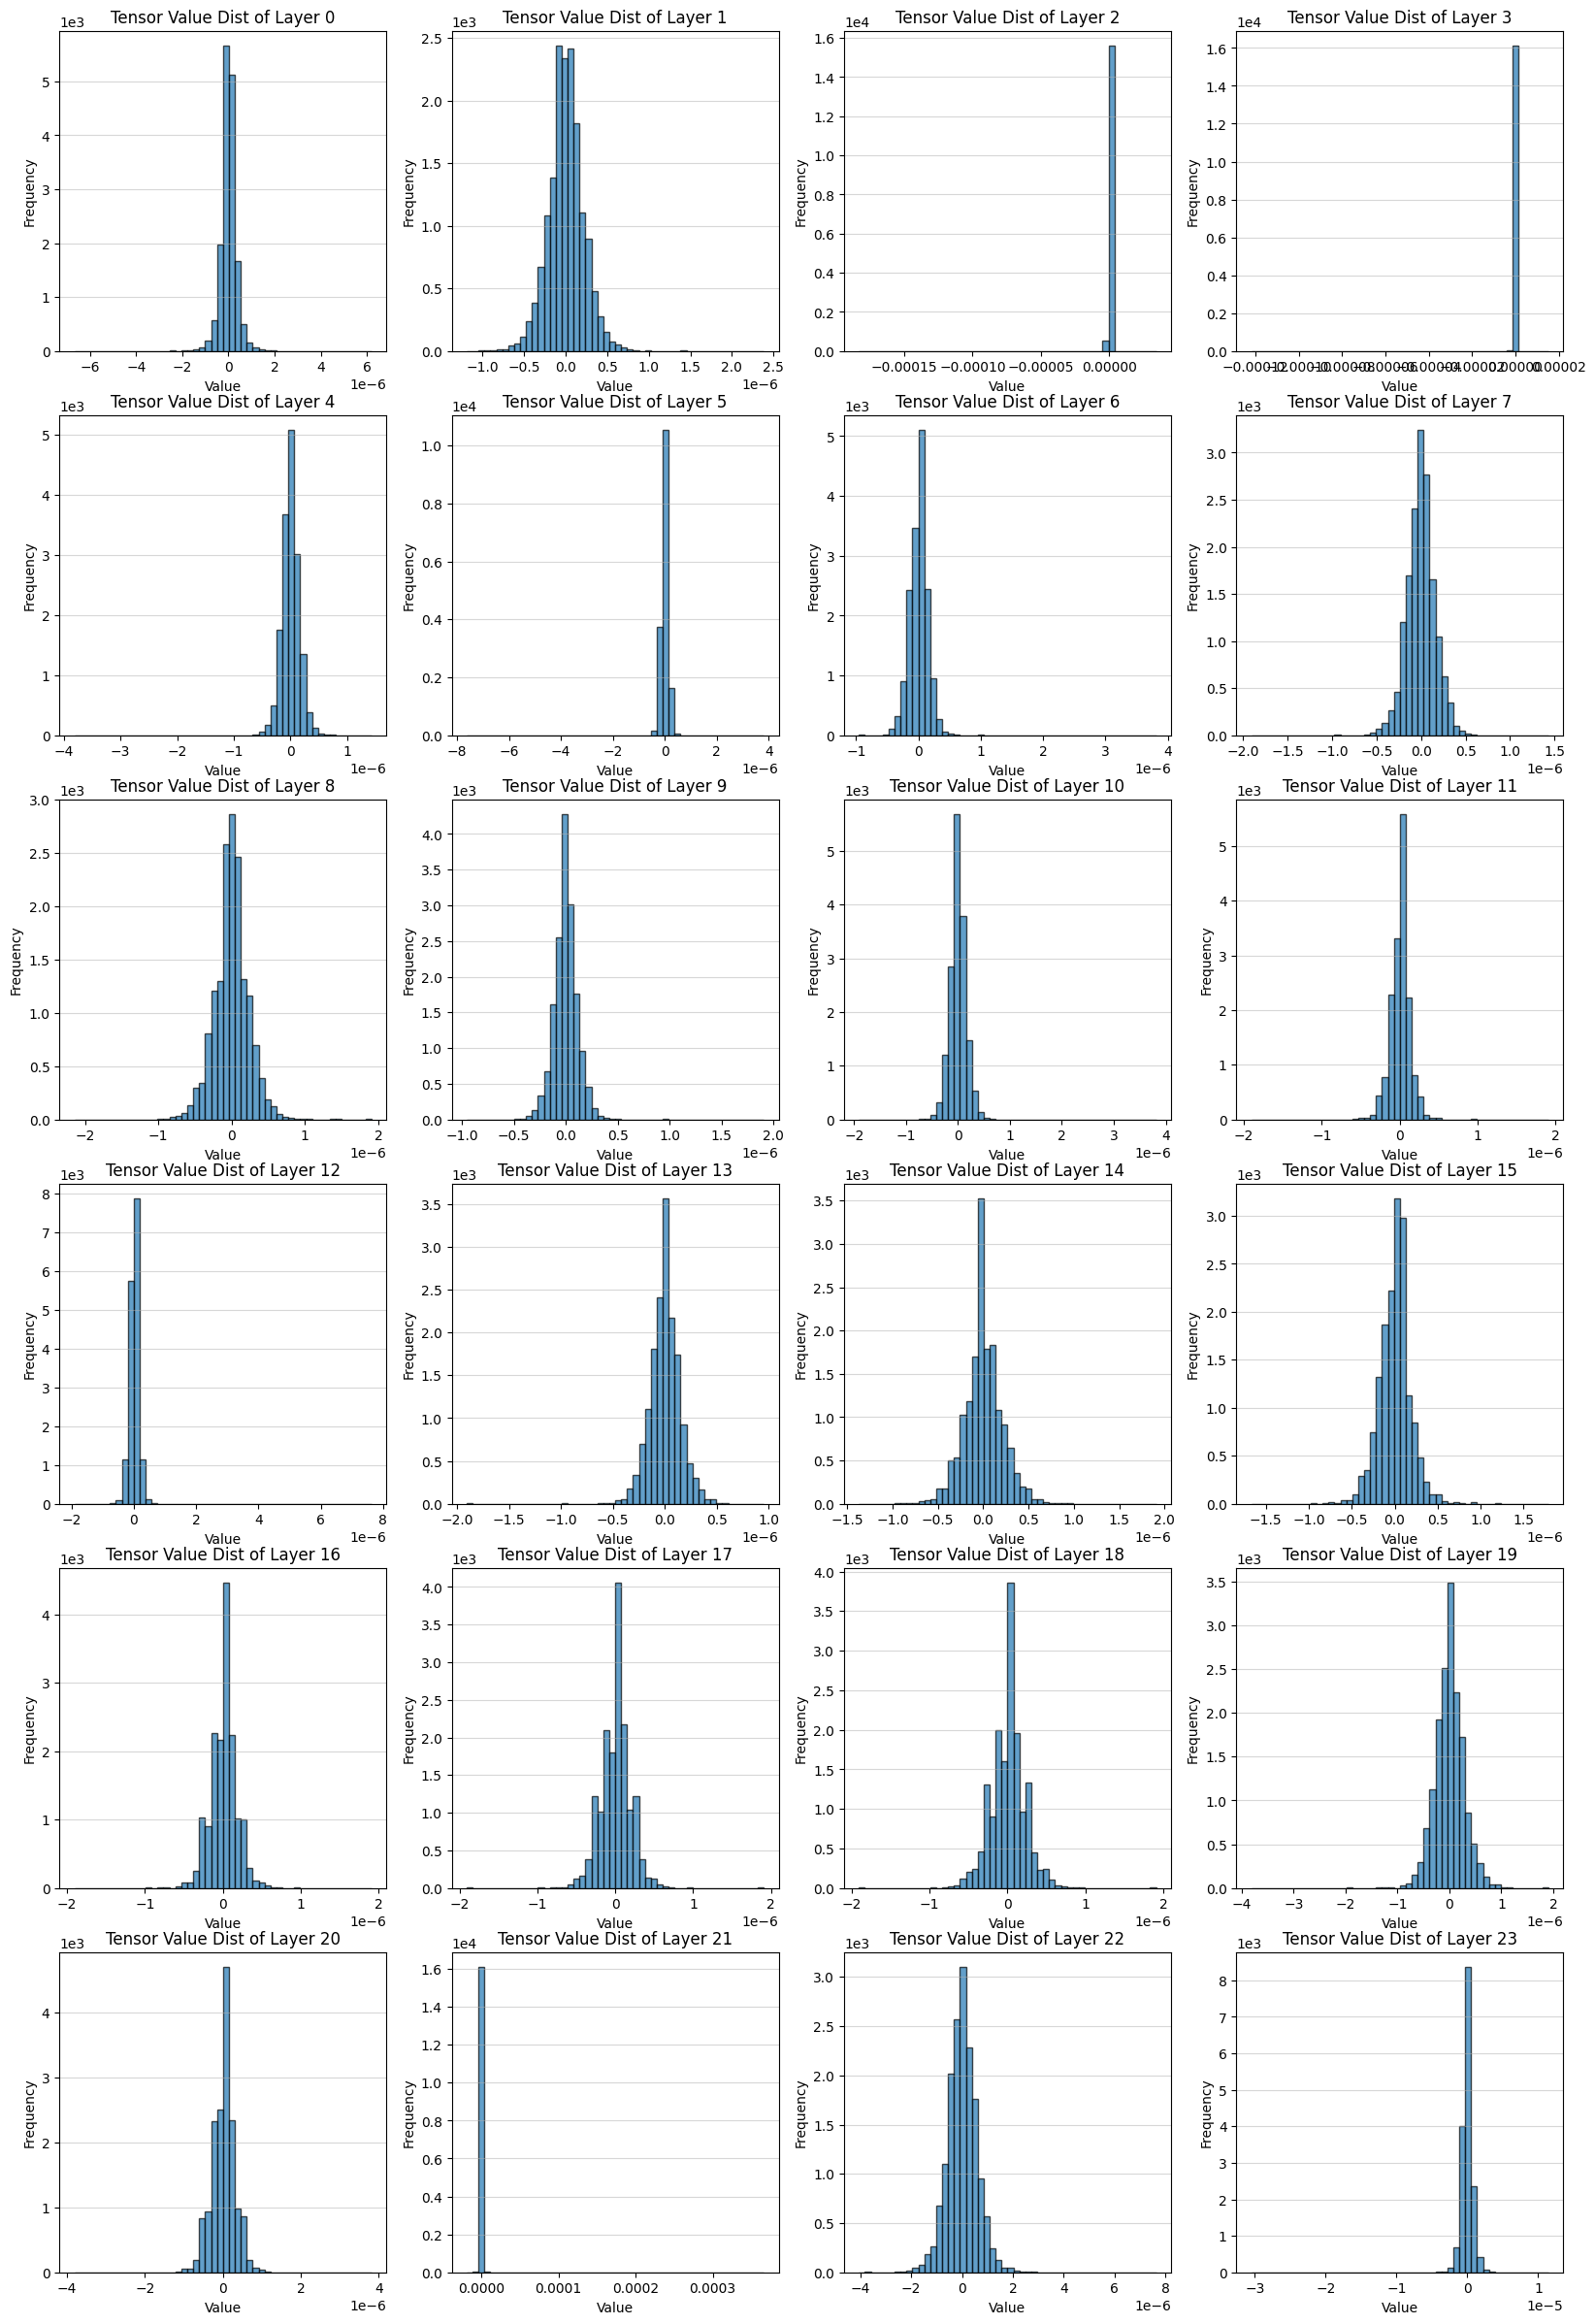

24


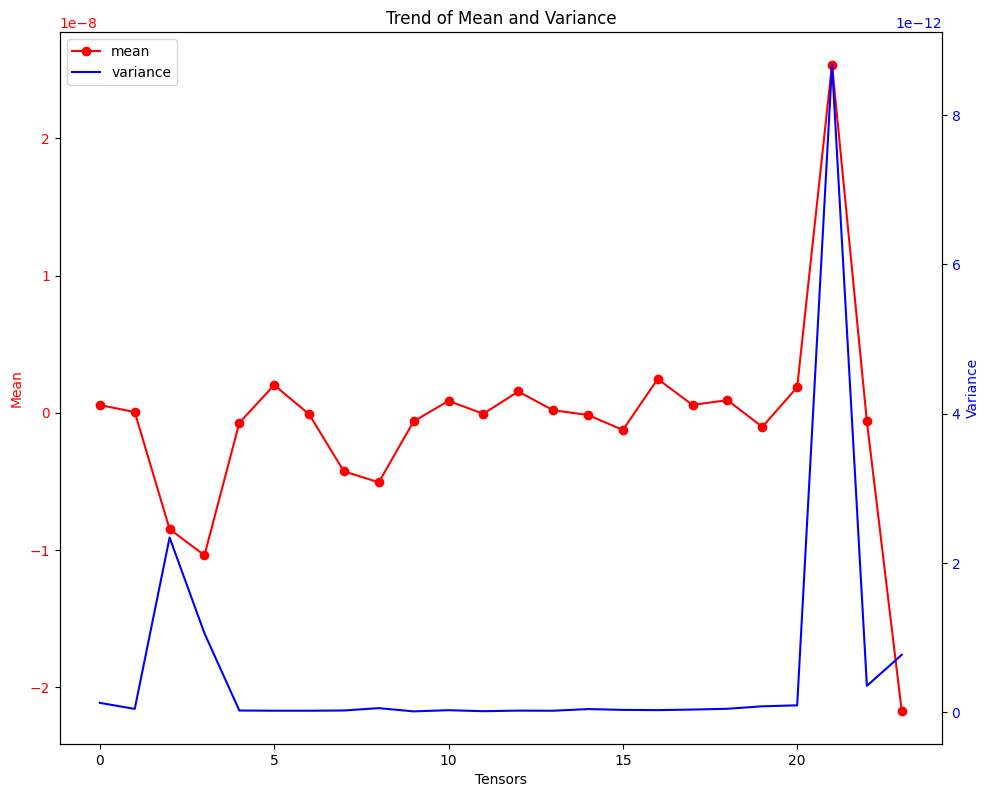

In [14]:
x, y = 6, 4
figsize = (y * 5, x * 5)
fig, axes = plt.subplots(x, y, figsize=figsize)

tensors = []
token_pos = 8
with torch.no_grad():
    for i in range(24):
        input_0 = hook_data[token_pos][forward_hook_module_names[i]]["input"][0] # tuple of 8 args
        output_0 = hook_data[token_pos][forward_hook_module_names[i]]["output"][0][0] # ...["output"][0] only contains one element
        module = eval(f"model.{forward_hook_module_names[i]}")
        output_1_0 = module.forward(*input_0)
        plot_tensor_histogram(
            output_1_0[0] - output_0, 
            ax = axes[i // y][i % y], 
            is_show = False,
            title = f"Tensor Value Dist of Layer {i}"
        )
        tensors.append(output_1_0[0] - output_0)  
plt.show()
plt.close()
print(len(tensors))
means, variances = plot_tensor_mean_and_variance(tensors)

<font color=red>‰∏çÁü•ÈÅì‰∏∫‰ªÄ‰πàÔºåÁî®input_1‰Ωú‰∏∫ËæìÂÖ•ÔºåÊâãÂä®Ë∑ë‰∏ÄÈÅçlayerÔºåÁªìÊûúÂíåoutput_1Á´üÁÑ∂ÂØπ‰∏ç‰∏äÔºü</font>

- Â∑≤Ëß£ÂÜ≥ÔºöÂõ†‰∏∫ËæìÂÖ•ÂèÇÊï∞Ê≤°ÊúâÂÖ®ÈÉ®hookÂà∞ÔºåËøô‰∏™ÊòØ‰∏™ÊØîËæÉÈöæ‰ª•Ëß£ÂÜ≥ÁöÑÈóÆÈ¢òÔºåÂç≥torchÁöÑhookÂ¶Ç‰ΩïÊçïËé∑‰ª•keywordÂΩ¢Âºè‰º†ÂÖ•ÁöÑÂèÇÊï∞
  - <font color=red>‰ΩÜÊòØ‰øÆÊîπ‰∫ÜÊ∫êÁ†Å‰πãÂêéÔºåÈô§‰∫ÜÁ¨¨0‰∏™tokenÊòØÂØπÁöÑ‰∏äÁöÑÔºåÂêéÈù¢ÁöÑtokenÁöÑlayerËæìÂÖ•ËæìÂá∫ËøòÊòØ‰∏çËÉΩÂØπ‰∏äÔºü</font>
    - Â∑≤Ëß£ÂÜ≥ÔºöÂèØËÉΩÊòØÁî®‰∫ÜkvcacheÁöÑÂéüÂõ†ÔºåhookÂà∞ÁöÑkvcacheÂèØËÉΩ‰∏çÂáÜÁ°ÆÔºåÊàëÊöÇÊó∂Êâæ‰∏çÂà∞ÂäûÊ≥ïËß£ÂÜ≥ÔºåÂè™ËÉΩÁ¶ÅÁî®cache‰∫ÜÔºåËøôÁßçÊÉÖÂÜµ‰∏ãÁ°ÆÂÆûÊòØÂØπÁöÑ‰∏äÁöÑ

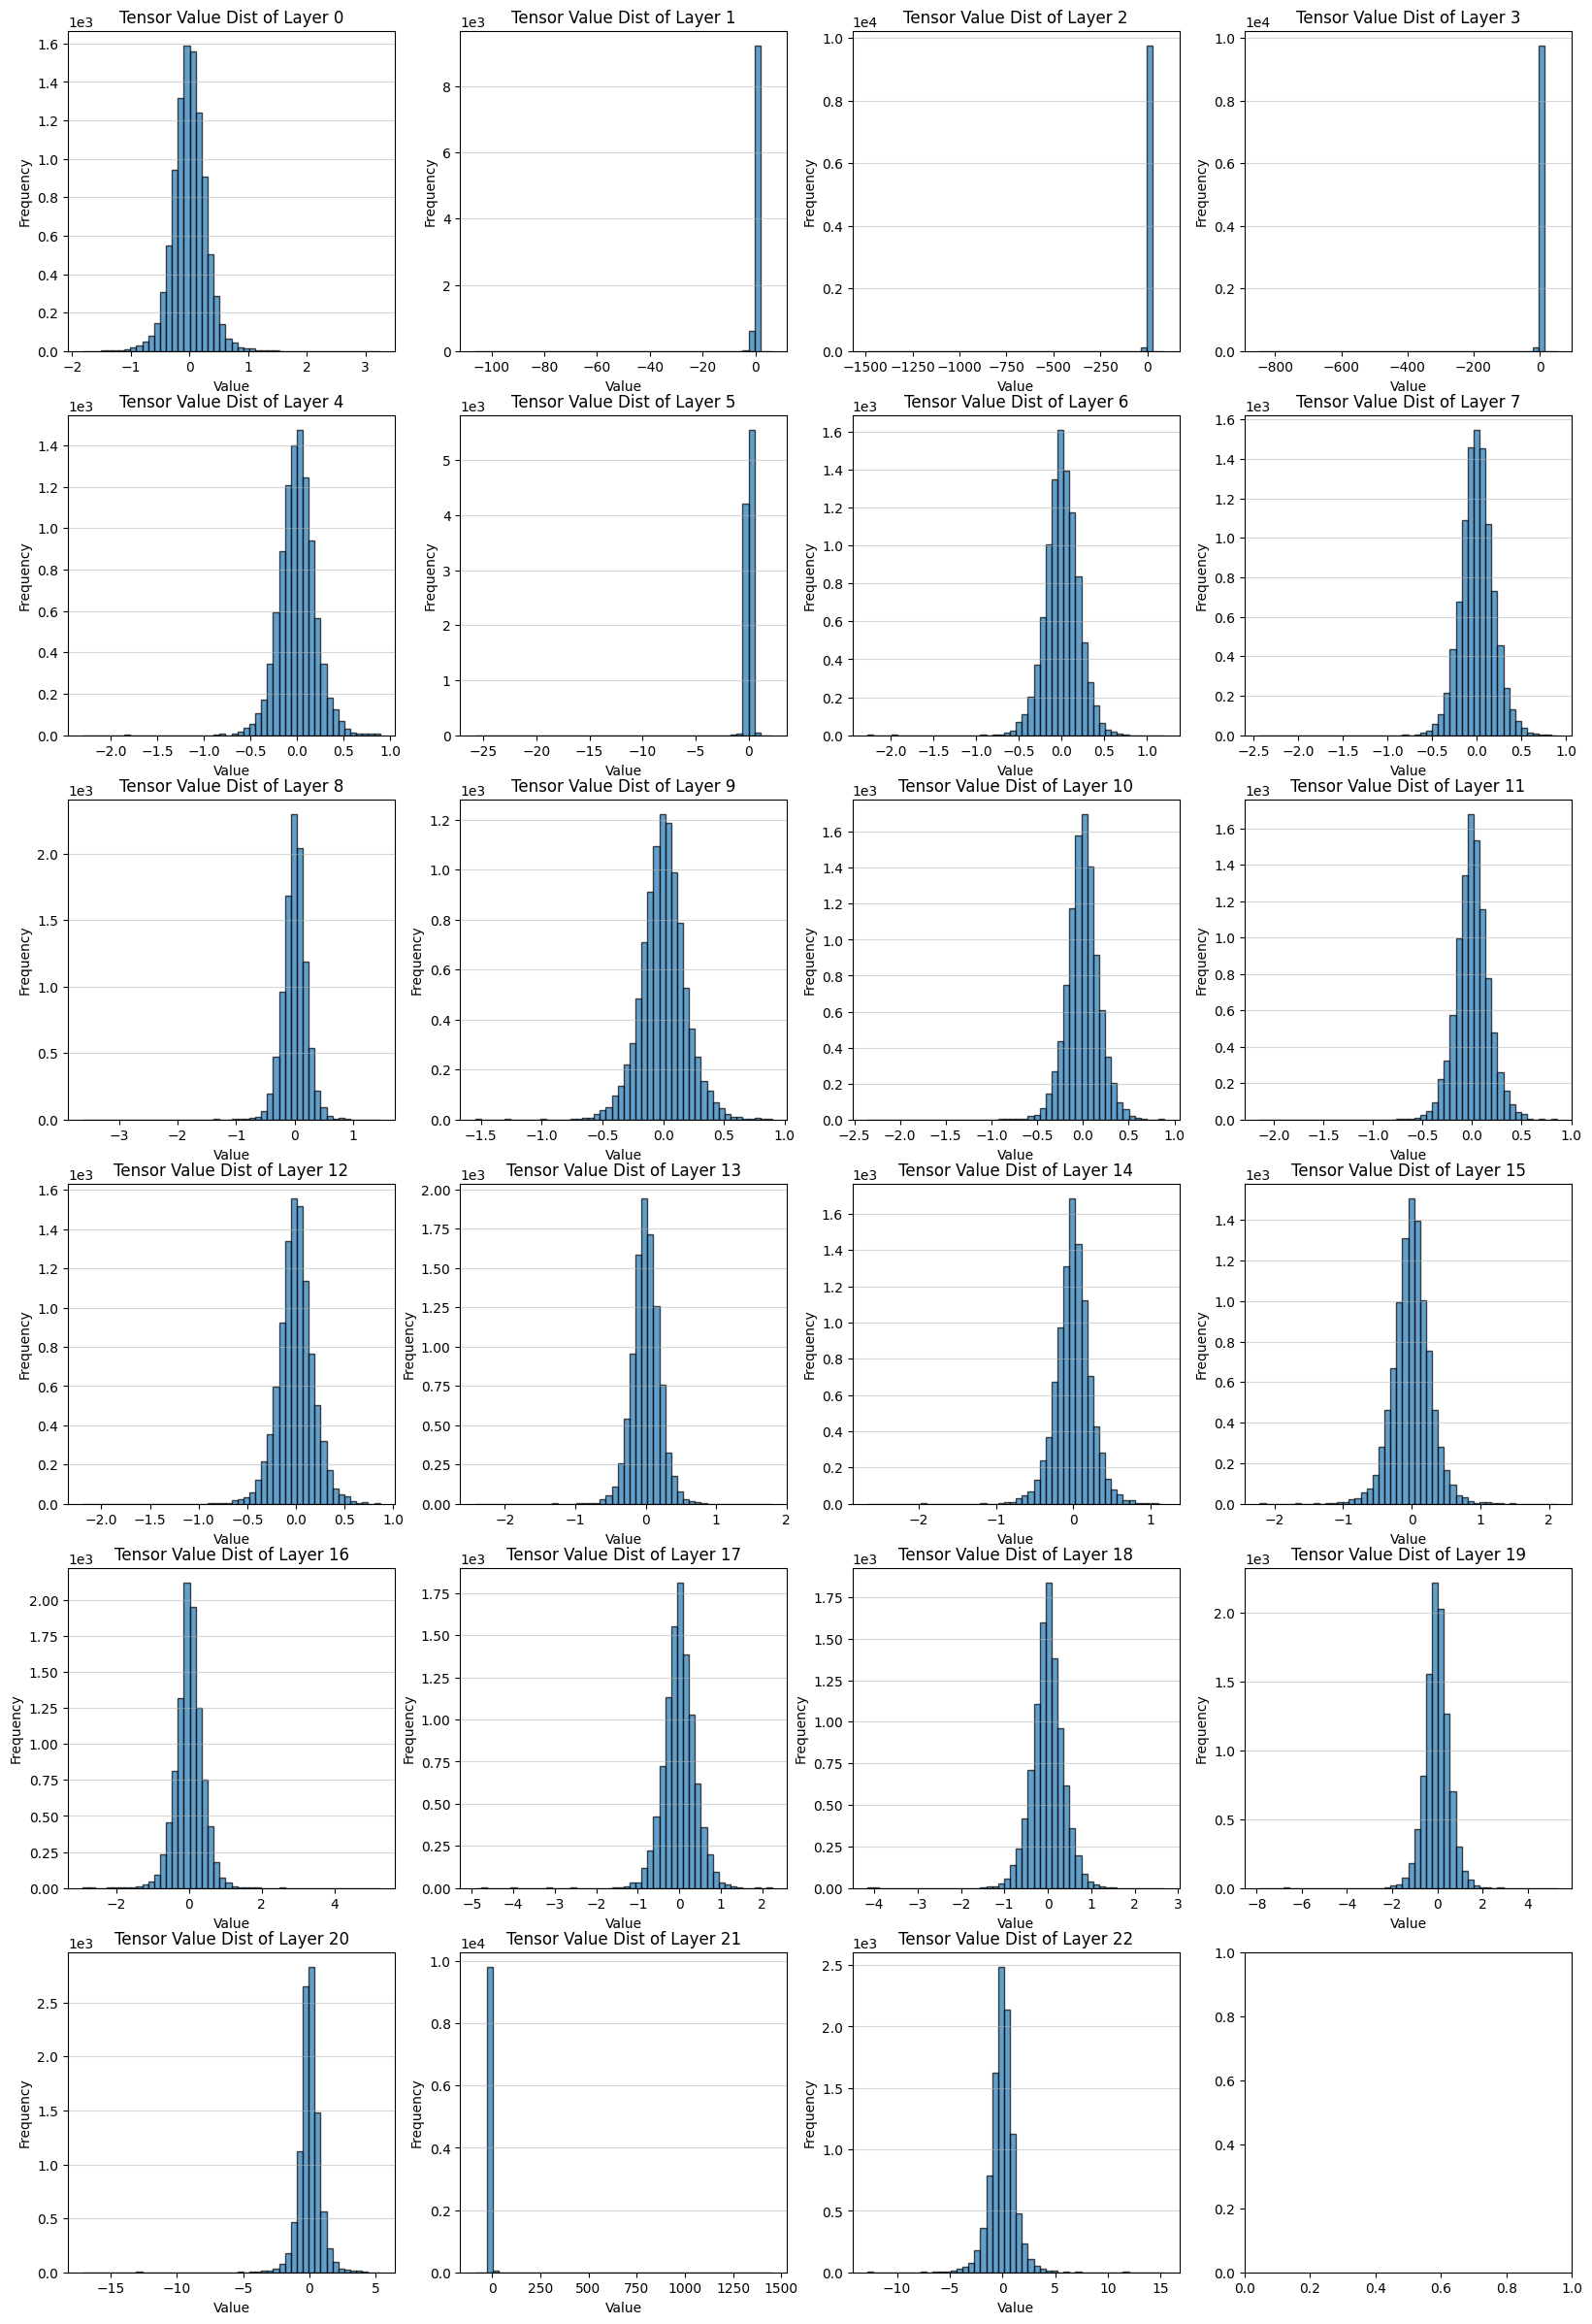

23


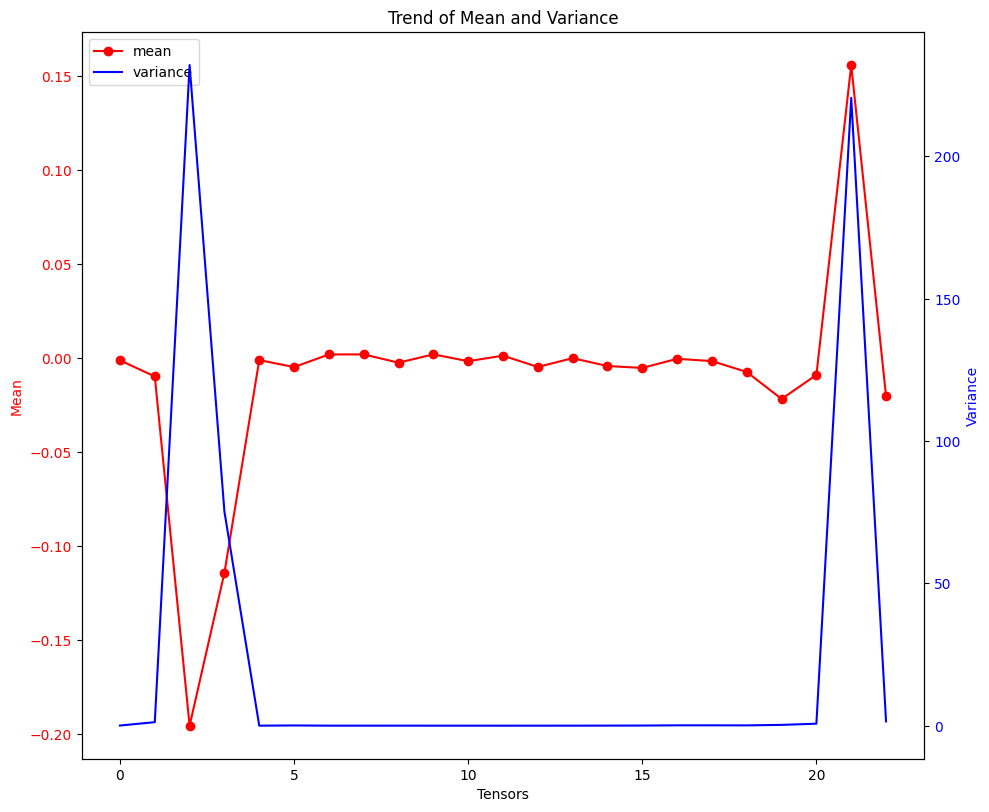

In [15]:
# skip-layer test
x, y = 6, 4
figsize = (y * 5, x * 5)
fig, axes = plt.subplots(x, y, figsize=figsize)

tensors = []
token_pos = 1
with torch.no_grad():
    for i in range(23):
        input_0 = hook_data[token_pos][forward_hook_module_names[i]]["input"][0] # tuple of 8 args
        output_1 = hook_data[token_pos][forward_hook_module_names[i + 1]]["output"][0][0] # ...["output"][0] only contains one element
        module = eval(f"model.{forward_hook_module_names[i + 1]}")
        output_1_1 = module.forward(*input_0)
        plot_tensor_histogram(
            output_1_1[0] - output_1, 
            ax = axes[i // y][i % y], 
            is_show = False,
            title = f"Tensor Value Dist of Layer {i}"
        )
        tensors.append(output_1_1[0] - output_1)
plt.show()
plt.close()
print(len(tensors))
means, variances = plot_tensor_mean_and_variance(tensors)

# Skip-LayerÁîüÊàêÊ°à‰æãÂàÜÊûêÔºàDeepSeek-R1-Distill-Qwen-1.5BÔºâ